In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import obspy
from obspy import UTCDateTime
import obspy.signal.filter
import sys           
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import math
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
warnings.filterwarnings("ignore")

In [3]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=11)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)
df_activity

,activity
UTC,
2004-09-23 09:00:00,s
2004-09-25 19:00:00,q
2004-09-26 00:00:00,c
2004-09-29 00:00:00,q
2004-10-01 19:02:00,a
2004-10-02 19:14:00,a
2004-10-02 19:14:00,t
2004-10-03 09:50:00,t
2004-10-03 11:30:00,et


# All Stations

In [4]:
def zsc(s):
    # log transform data
    log_s = np.log10(s).replace([np.inf, -np.inf], np.nan).dropna()
    
    # compute mean/std/min
    mn = np.mean(log_s)
    std = np.std(log_s)
    minzsc = np.min(log_s)                                                    

    # Calculate percentile
    s=(np.log10(s)-mn)/stdfzsc
    s=s.fillna(minzsc)
    s=10**s
    return s

def zsc2(s):
    s=zsc(s)
    s=s.rolling(window=2).min()
    s[0]=s[1]
    return s

In [5]:
def norm(s):
    diff_s = max(s)-min(s)
    s_norm = ((s - min(s))/diff_s)
    return s_norm

In [6]:
def mask_df(row):
    peaks, properties = scipy.signal.find_peaks(row, prominence=(row.rolling('10D').median()*100).to_numpy(), distance=len(row))
    row_masked = row.copy()
    try:
#         row_masked[row_masked>min(row_masked.iloc[properties['left_bases'][0]:properties['right_bases'][0]])]=np.nan
        row_masked.iloc[properties['left_bases'][0]-500:properties['right_bases'][0]+500]=np.nan
    except:
        pass
    return row_masked

In [31]:
df = pd.read_csv('../data/{}_{}_extended2.csv'.format(2000,'CDF'))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.resample('10min').median()
df

,rsam,mf,hf,dsar,ldsar,lhdsar,vsar,lhvsar,rms,rmes,...,zsc2_hf,zsc2_dsar,zsc2_ldsar,zsc2_lhdsar,zsc2_vsar,zsc2_lhvsar,zsc2_rms,zsc2_rmes,zsc2_pgv,zsc2_pga
time,,,,,,,,,,,,,,,,,,,,,
2000-08-06 07:40:00,23.478049,7.582845,8.109350,1.887055,6.209583,11.717828,0.935073,2.895181,0.000001,7.450070e-07,...,0.151387,2.026897,0.493085,0.556605,2.537970,0.559242,0.563353,0.257389,1.672622,1.138172
2000-08-06 07:50:00,6.573442,6.511503,7.202163,1.808982,1.980652,3.582963,0.904104,0.912704,0.000002,1.220342e-06,...,0.151387,2.026897,0.493085,0.556605,2.537970,0.559242,0.563353,0.257389,1.672622,1.138172
2000-08-06 08:00:00,6.394122,7.020264,7.285913,1.927188,1.642032,3.164504,0.963539,0.877601,0.000002,1.063161e-06,...,0.151387,2.026897,0.173507,0.285828,2.537970,0.447487,0.981383,1.136145,0.610945,1.138172
2000-08-06 08:10:00,6.195897,6.802768,7.506080,1.837384,1.624076,2.984051,0.906301,0.825451,0.000001,7.539684e-07,...,0.178338,3.768684,0.163199,0.208578,2.787915,0.315897,0.256701,0.270566,0.154872,3.664450
2000-08-06 08:20:00,6.361044,6.385615,8.075878,1.629805,1.834588,2.990021,0.790702,0.787660,0.000001,9.100812e-07,...,0.271938,0.031870,0.163199,0.208578,0.014196,0.242024,0.234684,0.270566,0.078069,1.963876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-11-16 04:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-11-16 04:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-11-16 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
year = 2006
sta = 'YEL'
all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/{}/*.csv'.format(year,sta)))
all_files

['/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_001.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_002.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_003.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_004.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_005.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_006.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_007.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_008.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_009.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_010.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_011.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_012.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_013.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2006/YEL/YEL_014.csv',
 '/dat

In [106]:
for year in range(1980,1980+1):
    all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/*/*.csv'.format(year)))
    sta_list = np.unique([file.split('/')[-2] for file in all_files])
#     sta_list = ['YEL']
    for sta in sta_list:
        print(sta)
        sta_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/{}/*.csv'.format(year,sta)))
        li = []
        for filename in sta_files:
            frame = pd.read_csv(filename)
            li.append(frame)

        df = pd.concat(li, axis=0, ignore_index=True)
#         df['time'] = '2006-10-13 00:00' # for station YEL jday 286
        df.set_index('time',inplace=True)
        df.index = pd.to_datetime(df.index).tz_localize(None)
        df.sort_index()

        # compute transforms and save
        df['zsc2_rsam'] = zsc2(df['rsam'])
        df['zsc2_mf'] = zsc2(df['mf'])
        df['zsc2_hf'] = zsc2(df['hf'])
        df['zsc2_dsar'] = zsc2(df['dsar'])
        df['zsc2_ldsar'] = zsc2(df['ldsar'])
        df['zsc2_lhdsar'] = zsc2(df['lhdsar'])
        df['zsc2_vsar'] = zsc2(df['vsar'])
        df['zsc2_lhvsar'] = zsc2(df['lhvsar'])
        df['zsc2_rms'] = zsc2(df['rms'])
        df['zsc2_rmes'] = zsc2(df['rmes'])
        df['zsc2_pgv'] = zsc2(df['pgv'])
        df['zsc2_pga'] = zsc2(df['pga'])

        df.to_csv('../data/{}_{}_extended2.csv'.format(year,sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')

APE
CDF
CWC
MUD
SPL


In [76]:
# create STA_extended2_long2.csv files including all avaivable years for one station
# sta_list = ['YEL']
all_files = sorted(glob.glob('../data/*_*_extended2.csv'))
sta_list = [file.split('_')[1] for file in all_files]
sta_list = np.unique(sta_list)
for sta in sta_list:
    all_files = sorted(glob.glob('../data/*_{}_extended2.csv'.format(sta)))
    print(all_files)
    li = []
    for filename in all_files:
        frame = pd.read_csv(filename)
        li.append(frame)

    df = pd.concat(li, axis=0, ignore_index=True)
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df.sort_index()
#     df.to_csv('../data/{}_extended2_long2.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')

['../data/2000_YEL_extended2.csv', '../data/2001_YEL_extended2.csv', '../data/2002_YEL_extended2.csv', '../data/2003_YEL_extended2.csv', '../data/2004_YEL_extended2.csv', '../data/2005_YEL_extended2.csv', '../data/2006_YEL_extended2.csv', '../data/2007_YEL_extended2.csv']


### Merge the data for YEL and VALT because the name changed due to repositionning

In [77]:
sta1 = 'YEL'
df1 = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta1))
df1.set_index('time',inplace=True)
df1.index = pd.to_datetime(df1.index).tz_localize(None)
df1 = df1.resample('10min').median()
df1

,rsam,mf,hf,dsar,ldsar,lhdsar,vsar,lhvsar,rms,rmes,...,zsc2_hf,zsc2_dsar,zsc2_ldsar,zsc2_lhdsar,zsc2_vsar,zsc2_lhvsar,zsc2_rms,zsc2_rmes,zsc2_pgv,zsc2_pga
time,,,,,,,,,,,,,,,,,,,,,
2000-02-05 20:00:00,14.689252,16.139029,14.206183,2.742902,1.374416,3.769887,1.136057,1.034004,2.394781e-07,1.321843e-07,...,0.224925,29.743051,3.678850,16.067454,16.516875,16.053014,0.196519,0.088486,0.154169,0.410855
2000-02-05 20:10:00,19.742020,21.934461,18.700305,2.751673,1.355797,3.730712,1.172947,1.055706,2.964153e-07,1.993704e-07,...,0.224925,29.743051,3.678850,16.067454,16.516875,16.053014,0.196519,0.088486,0.154169,0.410855
2000-02-05 20:20:00,18.230763,21.094441,19.550585,2.444665,1.311866,3.207074,1.078967,0.932492,3.069245e-07,2.105461e-07,...,0.340308,17.466447,3.169927,10.666088,12.839658,11.867322,0.330763,0.534493,0.194646,0.857655
2000-02-05 20:30:00,13.400612,14.909110,15.996387,2.218745,1.418201,3.146626,0.932030,0.837727,2.957226e-07,2.001716e-07,...,0.268962,11.154725,3.169927,10.130182,6.280570,8.675222,0.328879,0.543957,0.215754,0.449621
2000-02-05 20:40:00,17.479585,18.490357,22.197256,1.869949,1.608595,3.007992,0.833002,0.787466,3.574432e-07,2.227092e-07,...,0.268962,5.057833,4.508695,8.966107,3.628359,7.239696,0.328879,0.543957,0.215754,0.449621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-09-17 18:00:00,1083.626161,963.554893,2269.833532,0.742498,2.275547,1.689588,0.424505,0.477403,6.342740e-05,4.802058e-05,...,8267.824959,0.104145,5.931880,0.598174,0.181060,0.596108,4298.604342,66342.318595,144.292812,216.472654
2007-09-17 18:10:00,1109.583363,997.791245,2279.877408,0.766544,2.260027,1.732411,0.437651,0.486686,6.545827e-05,4.894200e-05,...,8267.824959,0.114142,5.779289,0.643175,0.201910,0.623961,4298.604342,66342.318595,144.292812,216.472654
2007-09-17 18:20:00,1111.768328,988.071003,2278.030878,0.754804,2.277945,1.719403,0.433739,0.488039,6.543047e-05,4.891133e-05,...,8374.935151,0.123432,5.779289,0.682534,0.223516,0.662594,4787.597434,71710.935699,156.757523,218.737434


In [78]:
sta2 = 'VALT'
df2 = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta2))
df2.set_index('time',inplace=True)
df2.index = pd.to_datetime(df2.index).tz_localize(None)
df2 = df2.resample('10min').median()
df2 = df2[df2.index > df1.index[-1]]
df2

,rsam,mf,hf,dsar,ldsar,lhdsar,vsar,lhvsar,rms,rmes,...,zsc2_hf,zsc2_dsar,zsc2_ldsar,zsc2_lhdsar,zsc2_vsar,zsc2_lhvsar,zsc2_rms,zsc2_rmes,zsc2_pgv,zsc2_pga
time,,,,,,,,,,,,,,,,,,,,,
2007-09-17 18:50:00,69.096594,148.609202,196.888899,1.389620,0.779535,1.083258,0.754787,0.350942,6.522046e-07,3.550315e-07,...,1.564820,0.049632,0.105358,0.059937,0.055996,0.052423,0.874363,0.870475,1.197259,1.758040
2007-09-17 19:00:00,107.085234,245.898948,344.671651,1.268472,0.699455,0.887239,0.713430,0.310688,1.633684e-06,3.722611e-07,...,1.749485,0.021951,0.037750,0.022502,0.033386,0.028127,0.874363,0.870475,3.029736,4.375002
2007-09-17 19:10:00,218.306657,408.466665,402.957242,1.817291,0.852935,1.550031,1.013672,0.541761,1.853530e-06,4.301500e-07,...,4.127240,0.021951,0.037750,0.022502,0.033386,0.028127,3.965372,0.943395,15.488324,16.259454
2007-09-17 19:20:00,75.028124,147.687864,173.035561,1.569835,0.828405,1.300460,0.853512,0.433599,5.745332e-07,3.440312e-07,...,1.435300,0.147707,0.187373,0.146966,0.173005,0.154506,0.709614,0.825188,0.473030,0.649851
2007-09-17 19:30:00,55.903796,123.992392,174.957972,1.300693,0.742281,0.965480,0.708698,0.319527,5.924937e-07,2.658391e-07,...,1.435300,0.027472,0.066266,0.034068,0.031409,0.032463,0.709614,0.532676,0.473030,0.649851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:10:00,33.863626,64.870321,101.241659,1.305498,0.872467,1.139004,0.640747,0.334483,5.201524e-07,3.438582e-07,...,1.019184,0.098611,0.526755,0.224704,0.109523,0.193996,0.639822,0.780851,0.318358,0.216670
2022-12-31 23:20:00,33.594929,63.600305,101.109547,1.278314,0.891613,1.139762,0.629024,0.332263,4.983652e-07,3.230628e-07,...,1.017469,0.089118,0.526755,0.224704,0.100857,0.190819,0.595486,0.690878,0.318358,0.216670
2022-12-31 23:30:00,28.323156,55.423621,86.789601,1.293371,0.852360,1.102417,0.638597,0.326343,4.305606e-07,2.837679e-07,...,0.835547,0.089118,0.473602,0.207769,0.100857,0.182501,0.452660,0.535637,0.228440,0.194663


In [79]:
df = pd.concat([df1, df2], axis=0)
df

,rsam,mf,hf,dsar,ldsar,lhdsar,vsar,lhvsar,rms,rmes,...,zsc2_hf,zsc2_dsar,zsc2_ldsar,zsc2_lhdsar,zsc2_vsar,zsc2_lhvsar,zsc2_rms,zsc2_rmes,zsc2_pgv,zsc2_pga
time,,,,,,,,,,,,,,,,,,,,,
2000-02-05 20:00:00,14.689252,16.139029,14.206183,2.742902,1.374416,3.769887,1.136057,1.034004,2.394781e-07,1.321843e-07,...,0.224925,29.743051,3.678850,16.067454,16.516875,16.053014,0.196519,0.088486,0.154169,0.410855
2000-02-05 20:10:00,19.742020,21.934461,18.700305,2.751673,1.355797,3.730712,1.172947,1.055706,2.964153e-07,1.993704e-07,...,0.224925,29.743051,3.678850,16.067454,16.516875,16.053014,0.196519,0.088486,0.154169,0.410855
2000-02-05 20:20:00,18.230763,21.094441,19.550585,2.444665,1.311866,3.207074,1.078967,0.932492,3.069245e-07,2.105461e-07,...,0.340308,17.466447,3.169927,10.666088,12.839658,11.867322,0.330763,0.534493,0.194646,0.857655
2000-02-05 20:30:00,13.400612,14.909110,15.996387,2.218745,1.418201,3.146626,0.932030,0.837727,2.957226e-07,2.001716e-07,...,0.268962,11.154725,3.169927,10.130182,6.280570,8.675222,0.328879,0.543957,0.215754,0.449621
2000-02-05 20:40:00,17.479585,18.490357,22.197256,1.869949,1.608595,3.007992,0.833002,0.787466,3.574432e-07,2.227092e-07,...,0.268962,5.057833,4.508695,8.966107,3.628359,7.239696,0.328879,0.543957,0.215754,0.449621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:10:00,33.863626,64.870321,101.241659,1.305498,0.872467,1.139004,0.640747,0.334483,5.201524e-07,3.438582e-07,...,1.019184,0.098611,0.526755,0.224704,0.109523,0.193996,0.639822,0.780851,0.318358,0.216670
2022-12-31 23:20:00,33.594929,63.600305,101.109547,1.278314,0.891613,1.139762,0.629024,0.332263,4.983652e-07,3.230628e-07,...,1.017469,0.089118,0.526755,0.224704,0.100857,0.190819,0.595486,0.690878,0.318358,0.216670
2022-12-31 23:30:00,28.323156,55.423621,86.789601,1.293371,0.852360,1.102417,0.638597,0.326343,4.305606e-07,2.837679e-07,...,0.835547,0.089118,0.473602,0.207769,0.100857,0.182501,0.452660,0.535637,0.228440,0.194663


In [80]:
df.to_csv('../data/YEL_VALT_extended2_long2.csv')

## Create extended2_long.csv files

In [53]:
param = 'mf'
df_median = pd.DataFrame()
sta_list = ['SEP','NED','HSR','EDM','SHW','STD','SOS','JUN','JRO','FL2','CDF','ELK','TDL','YEL_VALT']
for sta in sta_list:
    df = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df_read = df.resample('10min').median()[param]

    df_median[sta] = df_read
    new_index = pd.date_range(start='2000-01-01 00:00:00', end='2022-12-31 23:50:00', freq='10T')
    df_median = df_median.reindex(new_index)
    df_median.index.name = 'time'
    df_median.to_csv('../data/{}_extended2_long.csv'.format(param))

In [56]:
param = 'hf'
df_median = pd.DataFrame()
sta_list = ['SEP','NED','HSR','EDM','SHW','STD','SOS','JUN','JRO','FL2','CDF','ELK','TDL','YEL_VALT']
for sta in sta_list:
    df = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta))
    df.set_index('time', inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df_read = df.resample('10min').median()[param]

    df_median[sta] = df_read

# Create a new index range
new_index = pd.date_range(start='2000-01-01 00:00:00', end='2022-12-31 23:50:00', freq='10T')

# Reindex the DataFrame with the new index
df_median = df_median.reindex(new_index)

# Rename the column header
df_median = df_median.rename(columns={'YEL_VALT': 'YEL/VALT'})

# Set the index name
df_median.index.name = 'time'

# Save the DataFrame to CSV
df_median.to_csv('../data/{}_extended2_long.csv'.format(param))


## Here starts the plotting

### Prelim-Proposal Plot

In [14]:
# dome activity dataframe preparation ---------------------------------------------------------------------------------------------------
activity_dome = df_activity.copy()
activity_dome_start = activity_dome[activity_dome['activity' ]=='d'].take([0,2,3,4,5,6])
activity_dome_end = activity_dome[activity_dome['activity' ]=='ed'].take([1,2,3,4,5,6])
print(activity_dome_start, activity_dome_end)

           activity
UTC                
2004-10-11        d
2004-10-25        d
2005-01-03        d
2005-03-19        d
2005-08-06        d
2005-10-09        d            activity
UTC                
2004-10-24       ed
2004-12-18       ed
2005-03-09       ed
2005-07-18       ed
2005-10-09       ed
2006-04-01       ed


In [15]:
sta = 'allUWsta' # allUWsta, YEL_VALT
# read seismic data -------------------------------------------------------------------------------------------------------------------
# df = pd.read_csv('../data/1980_{}_extended2.csv'.format(sta)) # 1 year long
df = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df_read = df.resample('10min').median()

In [16]:
def head_and_tail(df, n=2): # function to show rows from the beginning and end of the df
    return pd.concat([df.head(n), df.tail(n)])

head_and_tail(df)

,rsam,mf,hf,dsar,ldsar,vsar,rms,rmes,pgv,pga,...,zsc2_ldsar,zsc2_vsar,zsc2_rms,zsc2_rmes,zsc2_pgv,zsc2_pga,lhdsar,lhvsar,zsc2_lhdsar,zsc2_lhvsar
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 23:40:00,8.129698,11.363140,20.637913,1.403804,1.879541,0.666528,3.279763e-07,2.052415e-07,1.469808e-06,0.000122,...,0.726137,4.848894,0.603515,0.615680,0.657761,0.423246,2.726442,0.714780,1.454453,2.194831
2022-12-31 23:50:00,3.927294,6.949612,13.281453,1.103715,1.118566,0.574990,1.165115e-07,5.650548e-08,6.269962e-07,0.000029,...,0.508880,4.595204,0.048988,0.032803,0.063107,0.040983,1.350959,0.374586,0.835660,1.885521


In [22]:
# preprocess seismic data -------------------------------------------------------------------------------------------------------------------
df = df_read.copy()
df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)

df = df.rolling('10D').median()
# df = df.rolling('1H').median()
# df = df.rolling('6H', center=True, closed='both').median()
# df = df[df.index<datetime.datetime(year,5,22)]

## Original short-time plot

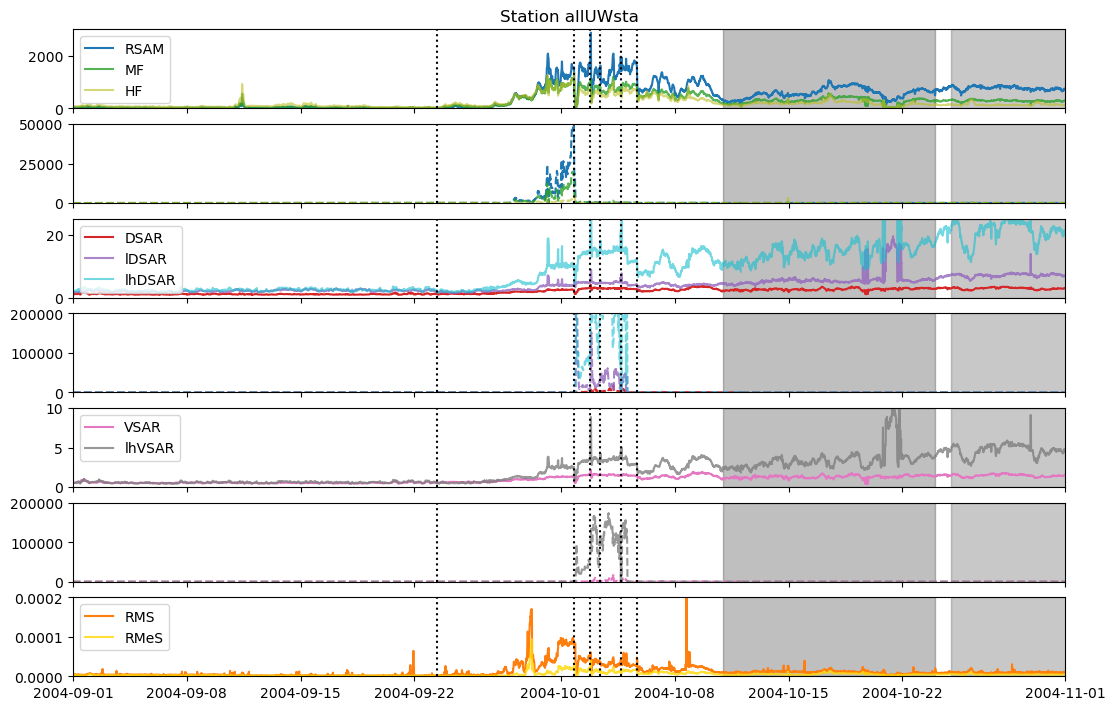

In [176]:
# crate figure LINEAR--------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4) = plt.subplots(7,1, sharex=True, figsize=(6.4*2, 4.8*0.25*7))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=1)
ax1.plot(df['mf'], label='MF', alpha=0.8, color='C2')
ax1.plot(df['hf'], label='HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

# ax11.plot(df['zsc2_rsam'],linestyle='--', alpha=1)
# ax11.plot(df['zsc2_mf'], linestyle='--', alpha=0.8, color='C2')
# ax11.plot(df['zsc2_hf'], linestyle='--', alpha=0.6, color='C8')
# ax11.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8, color='C4')
ax2.plot(df['lhdsar'], label='lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['lhdsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['lhdsar'].max()))

ax22.plot(df['zsc2_dsar'],linestyle='--', alpha=1, color='C3')
ax22.plot(df['zsc2_ldsar'], linestyle='--', alpha=0.8, color='C4')
ax22.plot(df['zsc2_lhdsar'], linestyle='--', alpha=0.6, color='C9')
ax22.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_lhdsar'].min()),
              max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_lhdsar'].max()))

ax3.plot(df['vsar'], label='VSAR', alpha=1, color='C6')
ax3.plot(df['lhvsar'], label='lhVSAR', alpha=0.8, color='C7')
ax3.set_ylim(min(df['vsar'].min(),df['lhvsar'].min()),max(df['vsar'].max(),df['lhvsar'].max()))

ax33.plot(df['zsc2_vsar'], linestyle='--', alpha=1, color='C6')
ax33.plot(df['zsc2_lhvsar'], linestyle='--', alpha=0.8, color='C7')
ax33.set_ylim(min(df['zsc2_vsar'].min(),df['zsc2_lhvsar'].min()),max(df['zsc2_vsar'].max(),df['zsc2_lhvsar'].max()))

ax4.plot(df['rms'], label='RMS', alpha=1, color='C1')
ax4.plot(df['rmes'], label='RMeS', alpha=0.8, color='gold')
ax4.set_ylim(min(df['rms'].min(),df['rmes'].min()),max(df['rms'].max(),df['rmes'].max()))

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
sdate = datetime.datetime(2004,10,11)
edate = datetime.datetime(2008,2,1)
ax1.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax11.axvspan(sdate, edate, alpha=0.25, color=color[i])
ax2.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax22.axvspan(sdate, edate, alpha=0.25, color=color[i])
ax3.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax33.axvspan(sdate, edate, alpha=0.25, color=color[i])
ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])

for i in [datetime.datetime(2004,9,23,9,0),datetime.datetime(2004,10,1,19,2),datetime.datetime(2004,10,2,19,15),
          datetime.datetime(2004,10,3,9,50),datetime.datetime(2004,10,4,16,43),datetime.datetime(2004,10,5,16,5)]:
    ax1.axvline(i, color='k',linestyle=':'); ax11.axvline(i, color='k',linestyle=':')
    ax2.axvline(i, color='k',linestyle=':'); ax22.axvline(i, color='k',linestyle=':')
    ax3.axvline(i, color='k',linestyle=':'); ax33.axvline(i, color='k',linestyle=':')
    ax4.axvline(i, color='k',linestyle=':')

    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

# linear y-axis
ax1.set_ylim(0,3000); ax11.set_ylim(0,50000)
ax2.set_ylim(0,25); ax22.set_ylim(0,200000)
ax3.set_ylim(0,10); ax33.set_ylim(0,200000)
ax4.set_ylim(0,2e-4)

# # linear zoom y-axis
# ax1.set_ylim(0,2000); ax11.set_ylim(0,100)
# ax2.set_ylim(0,20); ax22.set_ylim(0,100)
# ax3.set_ylim(0,5); ax33.set_ylim(0,100)
# ax4.set_ylim(0,1e-4)

# ax1.set_xlim(df.index[0], df.index[-1])
ax1.set_xlim(datetime.datetime(2004,9,1), datetime.datetime(2004,11,1))

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/single_sta/{}_lin_short_dome_roll1H.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig('../plots/multiyear/multi_sta/{}_lin_short_dome_roll1H_final.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

## separate z-score

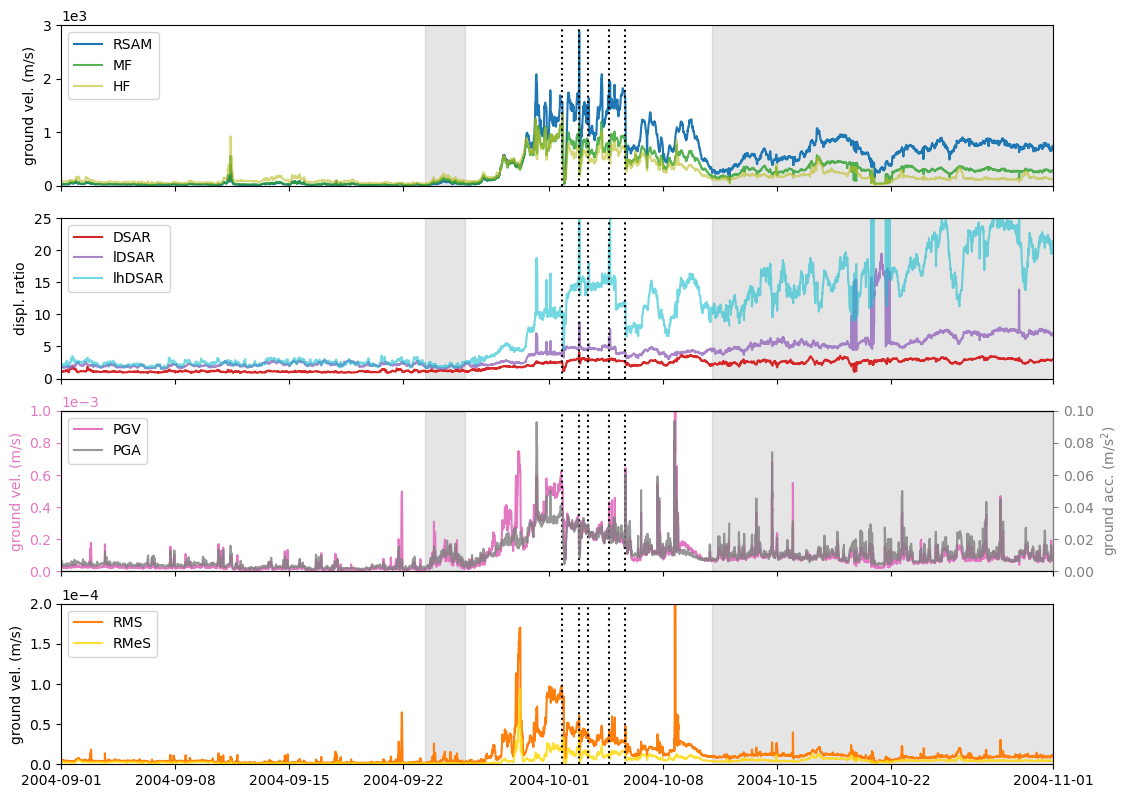

In [46]:
# crate figure LINEAR--------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*0.5*4))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=1)
ax1.plot(df['mf'], label='MF', alpha=0.8, color='C2')
ax1.plot(df['hf'], label='HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8, color='C4')
ax2.plot(df['lhdsar'], label='lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['lhdsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['lhdsar'].max()))

ax3.plot(df['pgv'], label='PGV', alpha=1, color='C6')
ax3.plot(np.nan, label='PGA', alpha=0.8, color='C7')
ax3.set_ylim(df['pgv'].min(),df['pgv'].max())

ax33 = ax3.twinx()
ax33.plot(df['pga'], label='PGA', alpha=0.8, color='C7')
ax33.set_ylim(df['pga'].min(),df['pga'].max())

ax4.plot(df['rms'], label='RMS', alpha=1, color='C1')
ax4.plot(df['rmes'], label='RMeS', alpha=0.8, color='gold')
ax4.set_ylim(min(df['rms'].min(),df['rmes'].min()),max(df['rms'].max(),df['rmes'].max()))

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax1.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax2.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax3.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])
sdates = [datetime.datetime(2004,9,23,9,0),datetime.datetime(2004,10,11)]
edates = [datetime.datetime(2004,9,25,19,0),datetime.datetime(2008,2,1)]

for (sdate,edate) in zip(sdates,edates):
    ax1.axvspan(sdate, edate, alpha=0.2, color='gray')
    ax2.axvspan(sdate, edate, alpha=0.2, color='gray')
    ax3.axvspan(sdate, edate, alpha=0.2, color='gray')
    ax4.axvspan(sdate, edate, alpha=0.2, color='gray')

for i in [datetime.datetime(2004,10,1,19,2),datetime.datetime(2004,10,2,19,15),
          datetime.datetime(2004,10,3,9,50),datetime.datetime(2004,10,4,16,43),datetime.datetime(2004,10,5,16,5)]:
    ax1.axvline(i, color='k',linestyle=':')
    ax2.axvline(i, color='k',linestyle=':')
    ax3.axvline(i, color='k',linestyle=':')
    ax4.axvline(i, color='k',linestyle=':')
    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
# ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

# y-axis label
ax1.set_ylabel('ground vel. (m/s)')
ax2.set_ylabel('displ. ratio')
ax3.set_ylabel('ground vel. (m/s)', color='C6')
ax33.set_ylabel('ground acc. (m/s$^2$)', color='C7')
ax4.set_ylabel('ground vel. (m/s)')

# color ticks and spines
ax3.spines['left'].set_color('C6')
ax3.xaxis.label.set_color('C6')
ax3.tick_params(axis='y', colors='C6')

ax33.spines['right'].set_color('C7')
ax33.xaxis.label.set_color('C7')
ax33.tick_params(axis='y', colors='C7')

# linear y-axis
ax1.set_ylim(0,3000)
ax2.set_ylim(0,25)
ax3.set_ylim(0,1e-3)
ax33.set_ylim(0,1e-1)
ax4.set_ylim(0,2e-4)

# scientific notation
ax1.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax4.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))

# # log y-axis
# ax1.set_yscale('log')
# ax2.set_yscale('log')
# ax3.set_yscale('log')
# ax33.set_yscale('log')
# ax4.set_yscale('log')

# ax1.set_ylim(1e1,1e4)
# ax2.set_ylim(5e-1,1e2)
# ax3.set_ylim(1e-6,1e-2)
# ax33.set_ylim(1e-3,1e-1)
# ax4.set_ylim(1e-6,5e-4)

# ax1.set_xlim(df.index[0], df.index[-1])
ax1.set_xlim(datetime.datetime(2004,9,1), datetime.datetime(2004,11,1))

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/multi_sta/{}_lin_short_dome_roll1H_final2.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig('../plots/multiyear/multi_sta/{}_log_short_dome_roll1H_nozsc_final.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

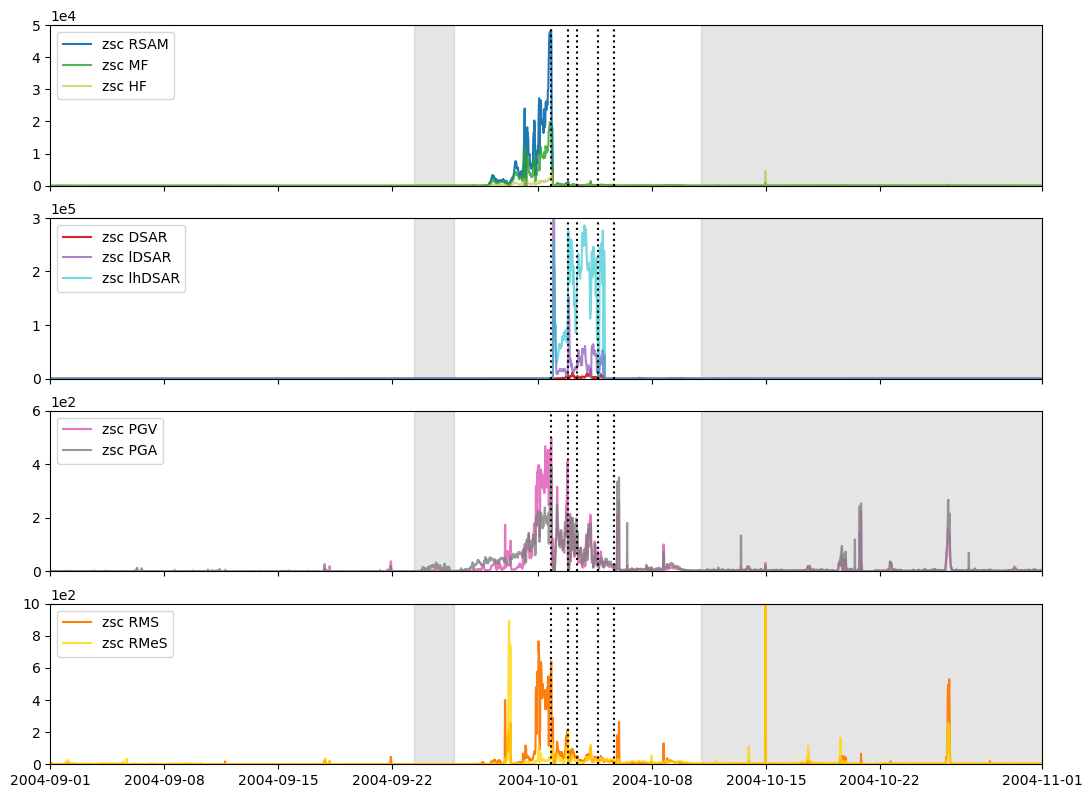

In [50]:
# crate figure --------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*0.5*4))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['zsc2_rsam'], label='zsc RSAM', alpha=1)
ax1.plot(df['zsc2_mf'], label='zsc MF', alpha=0.8, color='C2')
ax1.plot(df['zsc2_hf'], label='zsc HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),
             max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

ax2.plot(df['zsc2_dsar'], label='zsc DSAR', alpha=1, color='C3')
ax2.plot(df['zsc2_ldsar'], label='zsc lDSAR', alpha=0.8, color='C4')
ax2.plot(df['zsc2_lhdsar'], label='zsc lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_lhdsar'].min()),
             max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_lhdsar'].max()))

ax3.plot(df['zsc2_pgv'], label='zsc PGV', alpha=1, color='C6')
# ax3.plot(np.nan, label='zsc PGA', alpha=0.8, color='C7')
ax3.plot(df['zsc2_pga'], label='zsc PGA', alpha=0.8, color='C7')
ax3.set_ylim(df['zsc2_pgv'].min(),df['zsc2_pgv'].max())

# ax33 = ax3.twinx()
# ax33.plot(df['zsc2_pga'], label='zsc PGA', alpha=0.8, color='C7')
# ax33.set_ylim(df['zsc2_pga'].min(),df['zsc2_pga'].max())

ax4.plot(df['zsc2_rms'], label='zsc RMS', alpha=1, color='C1')
ax4.plot(df['zsc2_rmes'], label='zsc RMeS', alpha=0.8, color='gold')
ax4.set_ylim(min(df['zsc2_rms'].min(),df['zsc2_rmes'].min()),max(df['zsc2_rms'].max(),df['zsc2_rmes'].max()))

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax1.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax2.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax3.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])
sdates = [datetime.datetime(2004,9,23,9,0),datetime.datetime(2004,10,11)]
edates = [datetime.datetime(2004,9,25,19,0),datetime.datetime(2008,2,1)]

for (sdate,edate) in zip(sdates,edates):
    ax1.axvspan(sdate, edate, alpha=0.2, color='gray')
    ax2.axvspan(sdate, edate, alpha=0.2, color='gray')
    ax3.axvspan(sdate, edate, alpha=0.2, color='gray')
    ax4.axvspan(sdate, edate, alpha=0.2, color='gray')

for i in [datetime.datetime(2004,10,1,19,2),datetime.datetime(2004,10,2,19,15),
          datetime.datetime(2004,10,3,9,50),datetime.datetime(2004,10,4,16,43),datetime.datetime(2004,10,5,16,5)]:
    ax1.axvline(i, color='k',linestyle=':')
    ax2.axvline(i, color='k',linestyle=':')
    ax3.axvline(i, color='k',linestyle=':')
    ax4.axvline(i, color='k',linestyle=':')

    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

# linear y-axis
ax1.set_ylim(0,50000)
ax2.set_ylim(0,300000)
ax3.set_ylim(0,600)
# ax33.set_ylim(0,1000)
ax4.set_ylim(0,1000)

# scientific notation
ax1.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(5,5))
ax3.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
ax4.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# # log y-axis
# ax1.set_yscale('log')
# ax2.set_yscale('log')
# ax3.set_yscale('log')
# # ax33.set_yscale('log')
# ax4.set_yscale('log')

# ax1.set_ylim(1e-1,1e5)
# ax2.set_ylim(1e-1,1e6)
# ax3.set_ylim(1e-1,1e3)
# # ax33.set_ylim(1e-1,1e6)
# ax4.set_ylim(1e-1,1e3)

# ax1.set_xlim(df.index[0], df.index[-1])
ax1.set_xlim(datetime.datetime(2004,9,1), datetime.datetime(2004,11,1))

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/single_sta/{}_lin_short_dome_roll1H.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig('../plots/multiyear/multi_sta/{}_lin_short_dome_roll1H_zsc_final2.png'.format(sta), dpi=300, bbox_inches='tight')
# fig.show()

## 1980

In [219]:
df = df.loc[:datetime.datetime(1980,5,20)]
# df = df.rolling('6H').median()

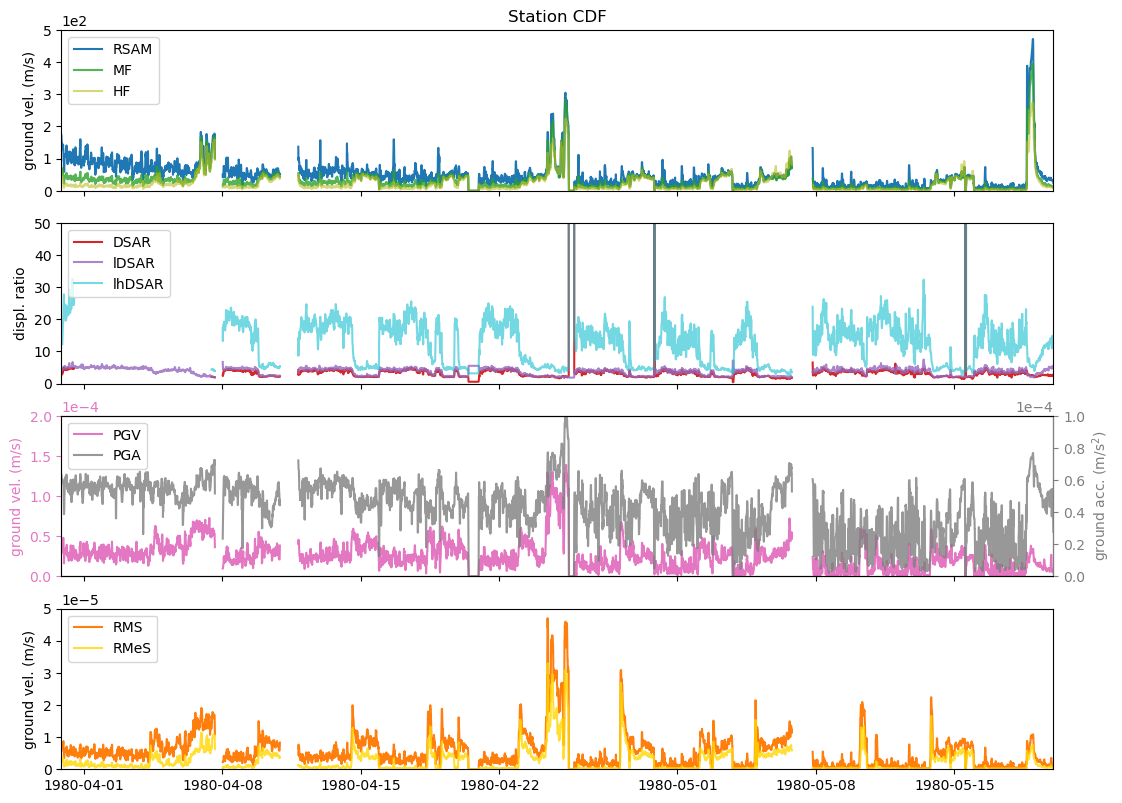

In [221]:
# crate figure LINEAR--------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*0.5*4))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=1)
ax1.plot(df['mf'], label='MF', alpha=0.8, color='C2')
ax1.plot(df['hf'], label='HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8, color='C4')
ax2.plot(df['lhdsar'], label='lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['lhdsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['lhdsar'].max()))

ax3.plot(df['pgv'], label='PGV', alpha=1, color='C6')
ax3.plot(np.nan, label='PGA', alpha=0.8, color='C7')
ax3.set_ylim(df['pgv'].min(),df['pgv'].max())

ax33 = ax3.twinx()
ax33.plot(df['pga'], label='PGA', alpha=0.8, color='C7')
ax33.set_ylim(df['pga'].min(),df['pga'].max())

ax4.plot(df['rms'], label='RMS', alpha=1, color='C1')
ax4.plot(df['rmes'], label='RMeS', alpha=0.8, color='gold')
ax4.set_ylim(min(df['rms'].min(),df['rmes'].min()),max(df['rms'].max(),df['rmes'].max()))

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax1.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax2.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax3.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])
sdate = datetime.datetime(2004,10,11)
edate = datetime.datetime(2008,2,1)
ax1.axvspan(sdate, edate, alpha=0.2, color='gray')
ax2.axvspan(sdate, edate, alpha=0.2, color='gray')
ax3.axvspan(sdate, edate, alpha=0.2, color='gray')
ax4.axvspan(sdate, edate, alpha=0.2, color='gray')

for i in [datetime.datetime(2004,9,23,9,0),datetime.datetime(2004,10,1,19,2),datetime.datetime(2004,10,2,19,15),
          datetime.datetime(2004,10,3,9,50),datetime.datetime(2004,10,4,16,43),datetime.datetime(2004,10,5,16,5)]:
    ax1.axvline(i, color='k',linestyle=':')
    ax2.axvline(i, color='k',linestyle=':')
    ax3.axvline(i, color='k',linestyle=':')
    ax4.axvline(i, color='k',linestyle=':')

    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

# y-axis label
ax1.set_ylabel('ground vel. (m/s)')
ax2.set_ylabel('displ. ratio')
ax3.set_ylabel('ground vel. (m/s)', color='C6')
ax33.set_ylabel('ground acc. (m/s$^2$)', color='C7')
ax4.set_ylabel('ground vel. (m/s)')

# color ticks and spines
ax3.spines['left'].set_color('C6')
ax3.xaxis.label.set_color('C6')
ax3.tick_params(axis='y', colors='C6')

ax33.spines['right'].set_color('C7')
ax33.xaxis.label.set_color('C7')
ax33.tick_params(axis='y', colors='C7')

# # linear y-axis MUD
# ax1.set_ylim(0,1200)
# ax2.set_ylim(0,25)
# ax3.set_ylim(0,2e-4)
# ax33.set_ylim(0,1e-4)
# ax4.set_ylim(0,5e-5)

# linear y-axis APE
ax1.set_ylim(0,500)
ax2.set_ylim(0,50)
ax3.set_ylim(0,2e-4)
ax33.set_ylim(0,1e-4)
ax4.set_ylim(0,5e-5)

# # scientific notation
ax1.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
ax33.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
ax4.ticklabel_format(axis='y', style='sci', scilimits=(-5,-5))

# # log y-axis
# ax1.set_yscale('log')
# ax2.set_yscale('log')
# ax3.set_yscale('log')
# ax33.set_yscale('log')
# ax4.set_yscale('log')

# ax1.set_ylim(1e0,1e4)
# ax2.set_ylim(5e-1,1e2)
# ax3.set_ylim(1e-6,1e-2)
# ax33.set_ylim(1e-6,1e-3)
# ax4.set_ylim(1e-7,1e-4)

ax1.set_xlim(df.index[0], df.index[-1])
# ax1.set_xlim(datetime.datetime(2004,9,1), datetime.datetime(2004,11,1))

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/1980/{}_lin_short_dome_roll1H.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig('../plots/multiyear/multi_sta/{}_log_short_dome_roll1H_nozsc_final.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

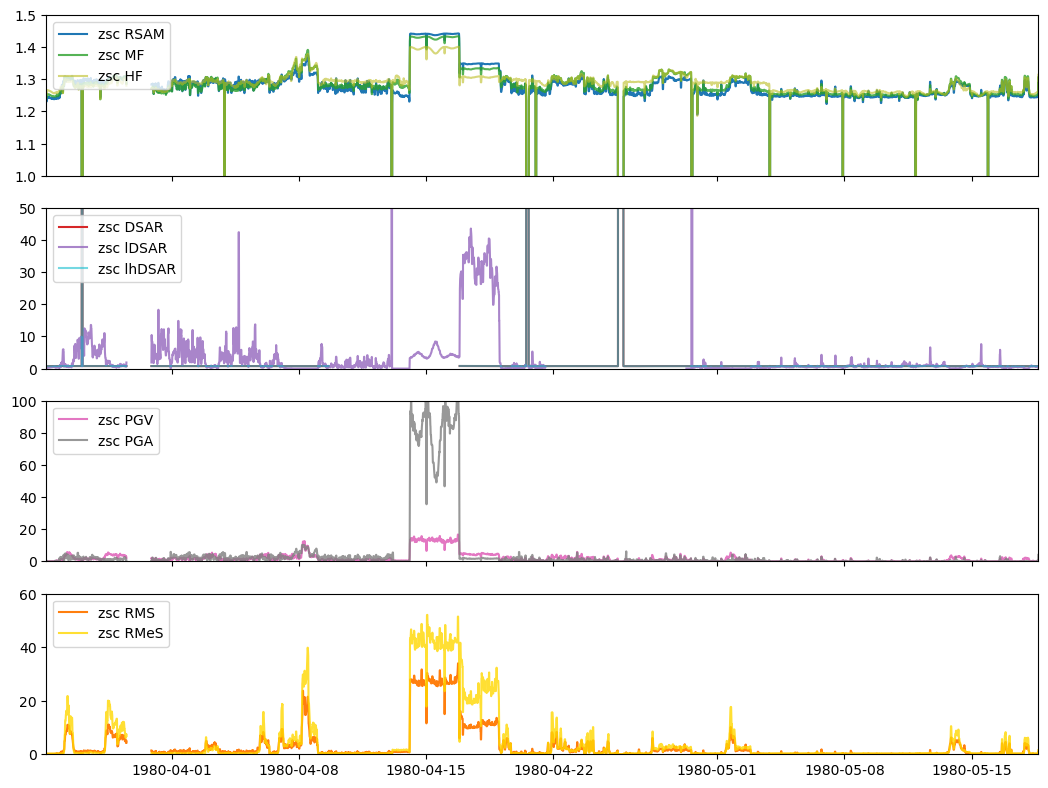

In [164]:
# crate figure --------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*0.5*4))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['zsc2_rsam'], label='zsc RSAM', alpha=1)
ax1.plot(df['zsc2_mf'], label='zsc MF', alpha=0.8, color='C2')
ax1.plot(df['zsc2_hf'], label='zsc HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),
             max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

ax2.plot(df['zsc2_dsar'], label='zsc DSAR', alpha=1, color='C3')
ax2.plot(df['zsc2_ldsar'], label='zsc lDSAR', alpha=0.8, color='C4')
ax2.plot(df['zsc2_lhdsar'], label='zsc lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_lhdsar'].min()),
             max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_lhdsar'].max()))

ax3.plot(df['zsc2_pgv'], label='zsc PGV', alpha=1, color='C6')
# ax3.plot(np.nan, label='zsc PGA', alpha=0.8, color='C7')
ax3.plot(df['zsc2_pga'], label='zsc PGA', alpha=0.8, color='C7')
ax3.set_ylim(df['zsc2_pgv'].min(),df['zsc2_pgv'].max())

# ax33 = ax3.twinx()
# ax33.plot(df['zsc2_pga'], label='zsc PGA', alpha=0.8, color='C7')
# ax33.set_ylim(df['zsc2_pga'].min(),df['zsc2_pga'].max())

ax4.plot(df['zsc2_rms'], label='zsc RMS', alpha=1, color='C1')
ax4.plot(df['zsc2_rmes'], label='zsc RMeS', alpha=0.8, color='gold')
ax4.set_ylim(min(df['zsc2_rms'].min(),df['zsc2_rmes'].min()),max(df['zsc2_rms'].max(),df['zsc2_rmes'].max()))

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax1.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax2.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax3.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])
sdate = datetime.datetime(2004,10,11)
edate = datetime.datetime(2008,2,1)
ax1.axvspan(sdate, edate, alpha=0.2, color='gray')
ax2.axvspan(sdate, edate, alpha=0.2, color='gray')
ax3.axvspan(sdate, edate, alpha=0.2, color='gray')
ax4.axvspan(sdate, edate, alpha=0.2, color='gray')

for i in [datetime.datetime(2004,9,23,9,0),datetime.datetime(2004,10,1,19,2),datetime.datetime(2004,10,2,19,15),
          datetime.datetime(2004,10,3,9,50),datetime.datetime(2004,10,4,16,43),datetime.datetime(2004,10,5,16,5)]:
    ax1.axvline(i, color='k',linestyle=':')
    ax2.axvline(i, color='k',linestyle=':')
    ax3.axvline(i, color='k',linestyle=':')
    ax4.axvline(i, color='k',linestyle=':')

    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

# linear y-axis
ax1.set_ylim(1,1.5)
ax2.set_ylim(0,50)
ax3.set_ylim(0,100)
# ax33.set_ylim(0,1000)
ax4.set_ylim(0,60)

# # scientific notation
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
# ax2.ticklabel_format(axis='y', style='sci', scilimits=(5,5))
# ax3.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
# ax4.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# # log y-axis
# ax1.set_yscale('log')
# ax2.set_yscale('log')
# ax3.set_yscale('log')
# # ax33.set_yscale('log')
# ax4.set_yscale('log')

# ax1.set_ylim(1e-1,1e5)
# ax2.set_ylim(1e-1,1e6)
# ax3.set_ylim(1e-1,1e3)
# # ax33.set_ylim(1e-1,1e6)
# ax4.set_ylim(1e-1,1e3)

ax1.set_xlim(df.index[0], df.index[-1])
# ax1.set_xlim(datetime.datetime(2004,9,1), datetime.datetime(2004,11,1))

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/single_sta/{}_lin_short_dome_roll1H.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig('../plots/multiyear/multi_sta/{}_log_short_dome_roll1H_zsc_final.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

(0.75, 0.85)

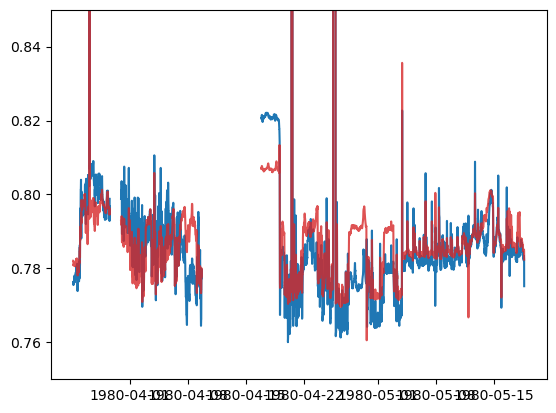

In [181]:
plt.plot(df['zsc2_lhdsar'])
plt.plot(df['zsc2_dsar'], color='C3', alpha=0.8)
plt.ylim(0.75,0.85)

## separate zsc long-time series

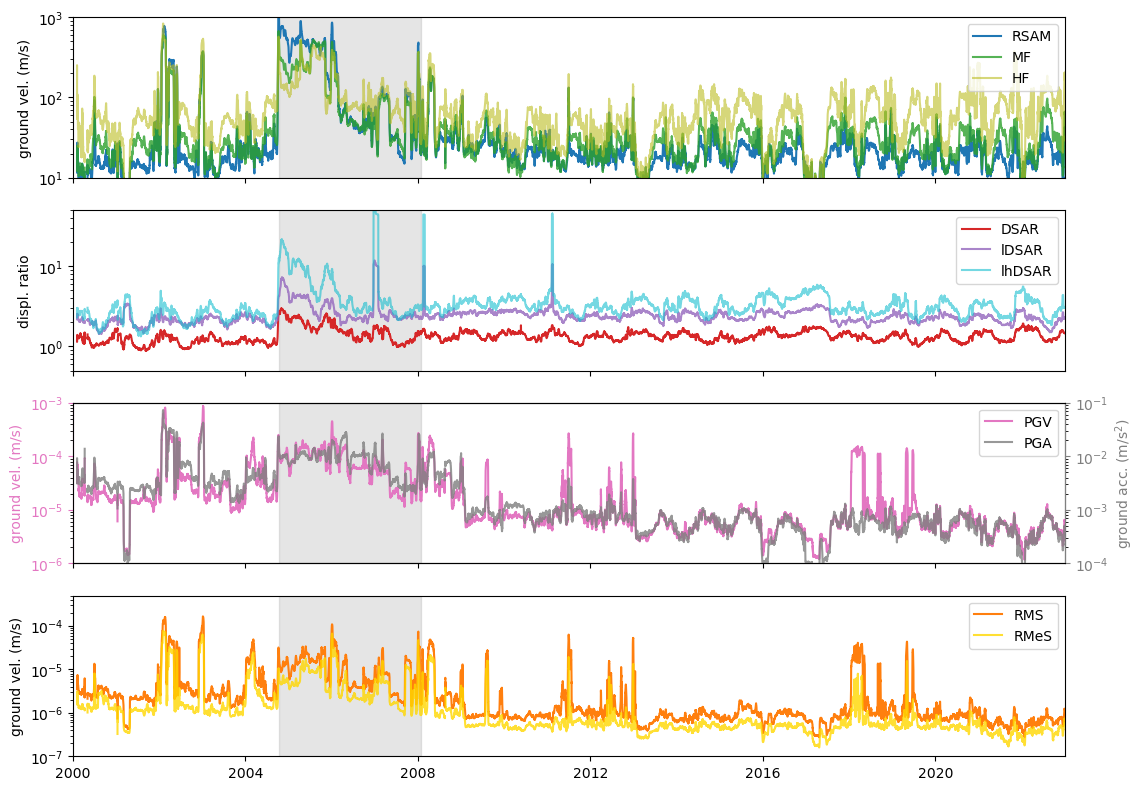

In [111]:
# crate figure-------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*2))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=1)
ax1.plot(df['mf'], label='MF', alpha=0.8, color='C2')
ax1.plot(df['hf'], label='HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8, color='C4')
ax2.plot(df['lhdsar'], label='lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['lhdsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['lhdsar'].max()))

ax3.plot(df['pgv'], label='PGV', alpha=1, color='C6')
ax3.plot(np.nan, label='PGA', alpha=0.8, color='C7')
ax3.set_ylim(df['pgv'].min(),df['pgv'].max())

ax33 = ax3.twinx()
ax33.plot(df['pga'], label='PGA', alpha=0.8, color='C7')
ax33.set_ylim(df['pga'].min(),df['pga'].max())

ax4.plot(df['rms'], label='RMS', alpha=1, color='C1')
ax4.plot(df['rmes'], label='RMeS', alpha=0.8, color='gold')
ax4.set_ylim(min(df['rms'].min(),df['rmes'].min()),max(df['rms'].max(),df['rmes'].max()))

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax1.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax11.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax2.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax22.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax3.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax33.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])

sdate = datetime.datetime(2004,10,11)
edate = datetime.datetime(2008,2,1)
ax1.axvspan(sdate, edate, alpha=0.2, color='gray')
ax2.axvspan(sdate, edate, alpha=0.2, color='gray')
ax3.axvspan(sdate, edate, alpha=0.2, color='gray')
ax4.axvspan(sdate, edate, alpha=0.2, color='gray')

# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

# y-axis label
ax1.set_ylabel('ground vel. (m/s)')
ax2.set_ylabel('displ. ratio')
ax3.set_ylabel('ground vel. (m/s)', color='C6')
ax33.set_ylabel('ground acc. (m/s$^2$)', color='C7')
ax4.set_ylabel('ground vel. (m/s)')

# color ticks and spines
ax3.spines['left'].set_color('C6')
ax3.xaxis.label.set_color('C6')
ax3.tick_params(axis='y', colors='C6')

ax33.spines['right'].set_color('C7')
ax33.xaxis.label.set_color('C7')
ax33.tick_params(axis='y', colors='C7')

# # linear y-axis
# ax1.set_ylim(0, 1e3)
# ax2.set_ylim(0, 20)
# ax3.set_ylim(0,5e-4)
# ax33.set_ylim(0,5e-2)
# ax4.set_ylim(0,5e-5)

# # scientific notation
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
# # ax2.ticklabel_format(axis='y', style='sci', scilimits=(5,5))
# ax3.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
# ax33.ticklabel_format(axis='y', style='sci', scilimits=(-2,-2))
# ax4.ticklabel_format(axis='y', style='sci', scilimits=(-5,-5))

# log y-axis
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax33.set_yscale('log')
ax4.set_yscale('log')

ax1.set_ylim(1e1, 1e3)
ax2.set_ylim(5e-1, 5e1)
ax3.set_ylim(1e-6,1e-3)
ax33.set_ylim(1e-4, 1e-1)
ax4.set_ylim(1e-7,5e-4)

ax1.set_xlim(df.index[0], df.index[-1])

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/multi_sta/{}_log_short_dome_roll10D_nozsc_final.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

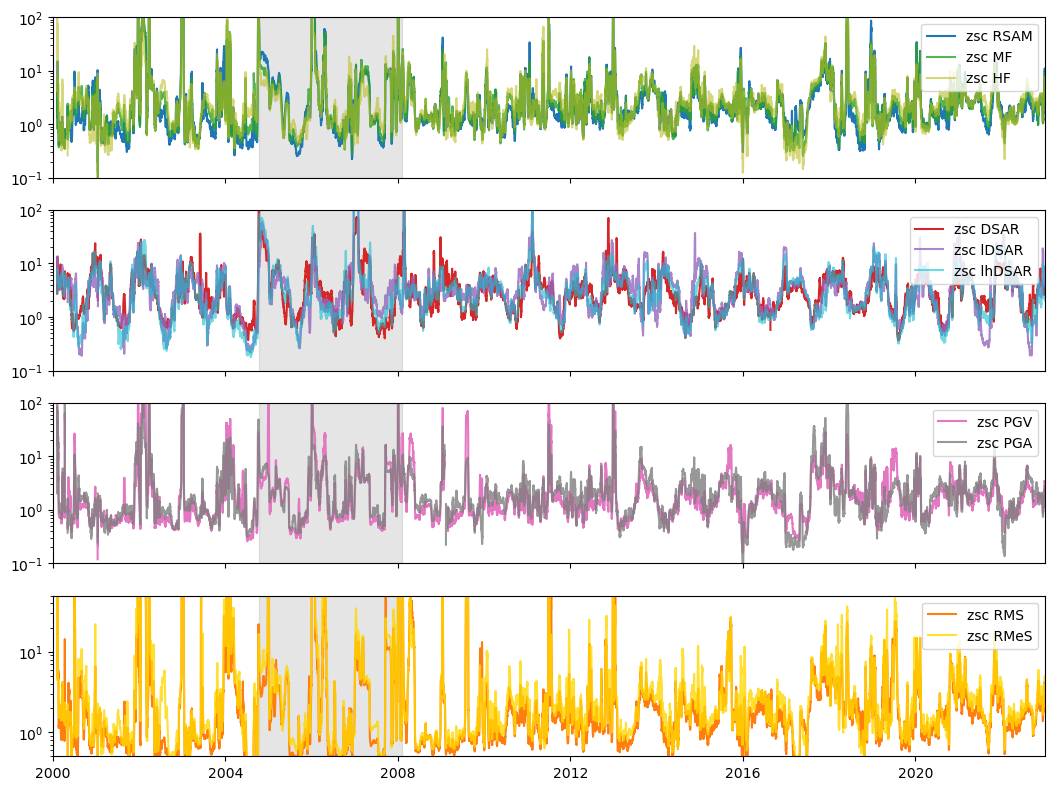

In [117]:
# crate figure -------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*2))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['zsc2_rsam'], label='zsc RSAM', alpha=1)
ax1.plot(df['zsc2_mf'], label='zsc MF', alpha=0.8, color='C2')
ax1.plot(df['zsc2_hf'], label='zsc HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),
             max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

ax2.plot(df['zsc2_dsar'], label='zsc DSAR', alpha=1, color='C3')
ax2.plot(df['zsc2_ldsar'], label='zsc lDSAR', alpha=0.8, color='C4')
ax2.plot(df['zsc2_lhdsar'], label='zsc lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_lhdsar'].min()),
             max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_lhdsar'].max()))

ax3.plot(df['zsc2_pgv'], label='zsc PGV', alpha=1, color='C6')
# ax3.plot(np.nan, label='zsc PGA', alpha=0.8, color='C7')
ax3.plot(df['zsc2_pga'], label='zsc PGA', alpha=0.8, color='C7')
ax3.set_ylim(df['zsc2_pgv'].min(),df['zsc2_pgv'].max())

# ax33 = ax3.twinx()
# ax33.plot(df['zsc2_pga'], label='zsc PGA', alpha=0.8, color='C7')
# ax33.set_ylim(df['zsc2_pga'].min(),df['zsc2_pga'].max())

ax4.plot(df['zsc2_rms'], label='zsc RMS', alpha=1, color='C1')
ax4.plot(df['zsc2_rmes'], label='zsc RMeS', alpha=0.8, color='gold')
ax4.set_ylim(min(df['zsc2_rms'].min(),df['zsc2_rmes'].min()),max(df['zsc2_rms'].max(),df['zsc2_rmes'].max()))

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax1.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax11.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax2.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax22.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax3.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax33.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])

sdate = datetime.datetime(2004,10,11)
edate = datetime.datetime(2008,2,1)
ax1.axvspan(sdate, edate, alpha=0.2, color='gray')
ax2.axvspan(sdate, edate, alpha=0.2, color='gray')
ax3.axvspan(sdate, edate, alpha=0.2, color='gray')
ax4.axvspan(sdate, edate, alpha=0.2, color='gray')

# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

# # linear y-axis
# ax1.set_ylim(0, 50)
# ax2.set_ylim(0, 50)
# ax3.set_ylim(0, 50)
# ax4.set_ylim(0, 50)

# log y-axis
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')

ax1.set_ylim(1e-1, 1e2)
ax2.set_ylim(1e-1, 1e2)
ax3.set_ylim(1e-1, 1e2)
ax4.set_ylim(5e-1, 5e1)

ax1.set_xlim(df.index[0], df.index[-1])

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/multi_sta/{}_log_short_dome_roll10D_zsc_final.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

## old long-term plot

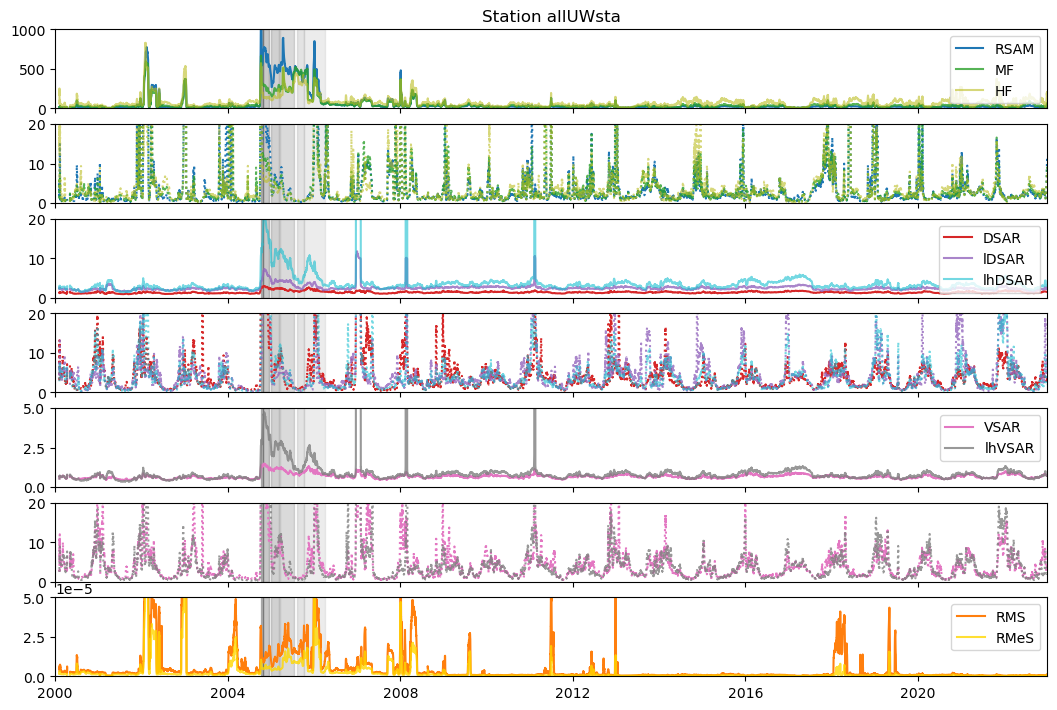

In [180]:
# crate figure LOG -------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4) = plt.subplots(7,1, sharex=True, figsize=(6.4*2, 4.8*0.25*7))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=1)
ax1.plot(df['mf'], label='MF', alpha=0.8, color='C2')
ax1.plot(df['hf'], label='HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=1)
ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.8, color='C2')
ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.6, color='C8')
ax11.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8, color='C4')
ax2.plot(df['lhdsar'], label='lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['lhdsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['lhdsar'].max()))

ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=1, color='C3')
ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.8, color='C4')
ax22.plot(df['zsc2_lhdsar'], linestyle=':', alpha=0.6, color='C9')
ax22.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_lhdsar'].min()),
              max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_lhdsar'].max()))

ax3.plot(df['vsar'], label='VSAR', alpha=1, color='C6')
ax3.plot(df['lhvsar'], label='lhVSAR', alpha=0.8, color='C7')
ax3.set_ylim(min(df['vsar'].min(),df['lhvsar'].min()),max(df['vsar'].max(),df['lhvsar'].max()))

ax33.plot(df['zsc2_vsar'], linestyle=':', alpha=1, color='C6')
ax33.plot(df['zsc2_lhvsar'], linestyle=':', alpha=0.8, color='C7')
ax33.set_ylim(min(df['zsc2_vsar'].min(),df['zsc2_lhvsar'].min()),max(df['zsc2_vsar'].max(),df['zsc2_lhvsar'].max()))

ax4.plot(df['rms'], label='RMS', alpha=1, color='C1')
ax4.plot(df['rmes'], label='RMeS', alpha=0.8, color='gold')
ax4.set_ylim(min(df['rms'].min(),df['rmes'].min()),max(df['rms'].max(),df['rmes'].max()))

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

for i in range(len(activity_dome_start)):
    sdate = activity_dome_start.index[i].to_pydatetime() # start date
    edate = activity_dome_end.index[i].to_pydatetime() # end date
    ax1.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax11.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax2.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax22.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax3.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax33.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])

# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

# log y-axis
# ax1.set_yscale('log');ax11.set_yscale('log')
# ax2.set_yscale('log');ax22.set_yscale('log')
# ax3.set_yscale('log');ax33.set_yscale('log')
# ax4.set_yscale('log')

ax1.set_ylim(0, 1e3); ax11.set_ylim(0, 20)
ax2.set_ylim(0, 20); ax22.set_ylim(0, 20)
ax3.set_ylim(0,5); ax33.set_ylim(0, 20)
ax4.set_ylim(0,5e-5)

# ax1.set_xlim(df.index[0], df.index[-1])
ax1.set_xlim(datetime.datetime(2000,1,1), datetime.datetime(2023,1,1))

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/single_sta/{}_log_long_dome_roll10D.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig('../plots/multiyear/multi_sta/{}_lin_long_dome_roll10D_final.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

## Average Mean

In [303]:
def df2dict(df, group_by="year"):
    """
    Group a DataFrame or time series by year, month, or day based on the DatetimeIndex.

    Args:
        df (pd.DataFrame or pd.Series): The input DataFrame or time series with a DatetimeIndex.
        group_by (str, optional): The time unit to group by. Accepted values are 'year', 'month', or 'day'. Defaults to 'year'.

    Returns:
        dict: A dictionary where keys are years, months, or days, and values are corresponding DataFrames or time series.

    Raises:
        ValueError: If the 'group_by' parameter is not one of 'year', 'month', or 'day'.
        TypeError: If 'df' is not a pandas DataFrame or Series.
        ValueError: If the index of 'df' is not a DatetimeIndex.
    """
    # Check if df is a DataFrame or Series
    if not isinstance(df, (pd.DataFrame, pd.Series)):
        raise TypeError("Input 'df' must be a pandas DataFrame or Series.")

    # Check if the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The index of 'df' must be a DatetimeIndex.")

    if group_by == "year":
        periods = df.index.year
    elif group_by == "month":
        periods = df.index.to_period("M")
    elif group_by == "day":
        periods = df.index.to_period("D")
    else:
        raise ValueError("Invalid value for 'group_by'. Use 'year', 'month', or 'day'.")

    df_dict = {}
    unique_periods = np.unique(periods)

    for period in unique_periods:
        df_period = df[periods == period]
        df_dict[period] = df_period

    return df_dict

def stack_space_year_param(df_stackSpace_year):
    """
    The df_yearlyParam is the statistical outputs, like min, max, mean, etc, of each year's data, which is from each column of the input dataframe.
    """
    df_yearlyParam = pd.DataFrame(
        np.nan,
        index=pd.Series(["max", "min", "mean", "median"]),
        columns=df_stackSpace_year.columns,
    )
    for col in df_stackSpace_year.columns:
        df_yearlyParam[col].loc["max"] = df_stackSpace_year[col].max()
        df_yearlyParam[col].loc["min"] = df_stackSpace_year[col].min()
        df_yearlyParam[col].loc["mean"] = df_stackSpace_year[col].mean()
        df_yearlyParam[col].loc["median"] = df_stackSpace_year[col].median()
    return df_yearlyParam

def stack_in_space(df_rsam_median):
    """
    Name: Stacking in Space\
    What it does: Analyses Data accross all stations to potential\
                 find a correlation between the climate and the region over the years.
    Input: .csv files of the Reformatted Time Series Data\
    Output: Average Seasonality over all stations, stacked in time series with reasonality removed.\
             Contains a column of maximum and minimum difference per year. Output to .csv file\
    """
    # remove the 29th February
    df_rsam_median = df_rsam_median.loc[
        ~((df_rsam_median.index.month == 2) & (df_rsam_median.index.day == 29))
    ]

    df_median_stackSpace = pd.DataFrame()
    df_rsam_median_f = df_rsam_median.fillna(0)

    # stack in space
    df_median_stackSpace["df_rsam_median_SS"] = df_rsam_median_f.apply(
        lambda row: row[row != 0].mean(), axis=1
    )

    df_dict = df2dict(
        df_median_stackSpace["df_rsam_median_SS"]
    )  # brake df up into years

    key_list = [key for key, value in df_dict.items()]
    time_list = df_dict[key_list[0]].index.strftime("%m/%d %H:%M:%S").to_list()
    df_stackSpace_year = pd.DataFrame(index=time_list, columns=key_list)

    for key, value in df_dict.items():
        df_stackSpace_year[key] = value.to_list()
    return df_median_stackSpace, df_stackSpace_year

In [81]:
df_short = df.copy()
df_short = df_short.iloc[:, [0,3]]
df_short

,rsam,dsar
time,,
2000-01-01 00:00:00,NaN,NaN
2000-01-01 00:10:00,NaN,NaN
2000-01-01 00:20:00,NaN,NaN
2000-01-01 00:30:00,NaN,NaN
2000-01-01 00:40:00,NaN,NaN
...,...,...
2022-12-31 23:10:00,40.720706,1.459021
2022-12-31 23:20:00,40.720706,1.458979
2022-12-31 23:30:00,40.720706,1.458907


In [106]:
df_stat_dsar = pd.DataFrame()
dict_dsar = df2dict(df_short, group_by="year")
for key, value in dict_dsar.items():
    hi_df = stack_space_year_param(value)
    df_stat_dsar[key] = hi_df['dsar']
df_stat_dsar

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
max,1.666278,1.689915,1.606833,1.523580,2.981346,2.586653,2.241343,1.850172,1.728358,1.649480,...,1.641536,1.697224,1.641866,1.787262,1.790280,1.544295,1.621045,1.661467,1.773090,1.929493
min,0.963846,0.882532,0.925188,1.008465,0.967995,1.439373,1.122614,0.984656,1.105963,1.169118,...,1.144773,1.046425,1.083377,1.269287,1.184937,1.098722,0.992147,1.034222,1.099436,1.126894
mean,1.181670,1.124089,1.181900,1.195700,1.494331,2.011868,1.468552,1.303304,1.346033,1.404636,...,1.388051,1.306648,1.298280,1.478713,1.519682,1.276890,1.251052,1.307108,1.366803,1.456257
median,1.132921,1.074971,1.194931,1.169537,1.173130,2.041259,1.458787,1.199454,1.324154,1.430669,...,1.383432,1.306355,1.291217,1.445680,1.529919,1.271836,1.235018,1.297400,1.340785,1.486574


In [107]:
df_stat_ll = pd.DataFrame()
dict_ll = df2dict(lakelevel, group_by="year")
for key, value in dict_ll.items():
    hi_df = stack_space_year_param(value)
    df_stat_ll[key] = hi_df['rel_LakeLevel(meter)']
df_stat_ll

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
max,2.237232,1.691640,1.758696,2.179320,1.929384,1.627632,2.359152,2.554224,3.230880,2.481072,...,2.993136,3.099816,6.111240,3.038856,1.898904,2.359152,2.676144,2.298192,2.910840,3.255264
min,0.758952,0.082296,0.000000,0.222504,0.597408,0.249936,0.374904,0.454152,0.859536,0.719328,...,1.075944,0.850392,1.139952,0.789432,0.448056,0.810768,1.277112,0.844296,0.844296,1.219200
mean,1.461416,0.865375,0.799046,1.084679,1.200104,0.969773,1.540150,1.560175,1.777776,1.575003,...,2.112523,1.943656,2.969452,1.825900,1.189641,1.508395,1.982888,1.738913,1.918775,2.019058
median,1.524000,0.954024,0.880872,1.124712,1.208532,1.002792,1.700784,1.780032,1.499616,1.537716,...,2.084832,1.975104,2.606040,1.670304,1.301496,1.499616,1.905000,1.886712,2.176272,2.036064


In [149]:
def fit_linear_trend(row):
    """
    Fit a linear trend to a Pandas DataFrame row.

    Parameters:
        row (pandas.Series): The row for which to fit the linear trend.

    Returns:
        Tuple: Coefficients of the linear fit (slope, intercept).
    """
    x_values = np.arange(len(row))
    coefficients = np.polyfit(x_values, row, 1)
    return coefficients

# Fit a linear trend to row
slope_dsar, intercept_dsar = fit_linear_trend(df_stat_dsar.loc['median'])
slope_ll, intercept_ll = fit_linear_trend(df_stat_ll.loc['median'])

# Trend line
x_dsar = np.arange(len(df_stat_dsar.columns.tolist()))
x_ll = np.arange(len(df_stat_ll.columns.tolist()))

trend_line_dsar = slope_dsar * x_dsar + intercept_dsar
trend_line_ll = slope_ll * x_ll + intercept_ll

# Display the results
print(f"DSAR - Slope: {round(slope_dsar,3)}, Intercept: {round(intercept_dsar,3)}")
print(f"Lake - Slope: {round(slope_ll,3)}, Intercept: {round(intercept_ll,3)}")

DSAR - Slope: 0.006, Intercept: 1.28
Lake - Slope: 0.039, Intercept: 1.259


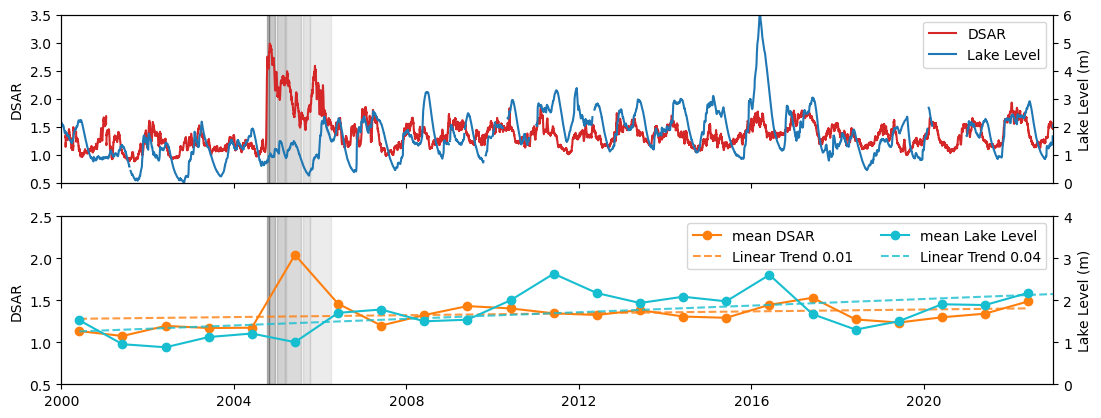

In [182]:
# crate figure lake level--------------------------------------------------------------------------------------------------------------------------
fig, (ax2, ax3) = plt.subplots(2,1,sharex=True,figsize=(6.4*2, 4.8))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
# ax1.plot(df['rsam'], label='2-5 Hz', alpha=1)
# ax1.plot(df['mf'], label='4.5-8 Hz', alpha=0.8, color='C2')
# ax1.plot(df['hf'], label='8-16 Hz', alpha=0.6, color='C8')

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')

ax2.plot(np.nan, label='Lake Level', alpha=1, color='C0')

ax22 = ax2.twinx()
ax22.plot(lakelevel['rel_LakeLevel(meter)'], label ='Lake Level')

ax3.plot([pd.to_datetime(f'{col}-06-01') for col in df_stat_dsar.columns.tolist()], df_stat_dsar.loc['median'],
         label='mean DSAR', alpha=1, color='C1',  linestyle='-', marker='o')
ax3.plot([pd.to_datetime(f'{col}-06-01') for col in df_stat_dsar.columns.tolist()], trend_line_dsar,
         label=f'Linear Trend {slope_dsar:.2f}', alpha=0.8, color='C1',  linestyle='--')

ax3.plot(np.nan, label='mean Lake Level', alpha=1, color='C9',  linestyle='-', marker='o')
ax3.plot(np.nan, label=f'Linear Trend {slope_ll:.2f}', alpha=0.8, color='C9',  linestyle='--')

ax33 = ax3.twinx()
ax33.plot([pd.to_datetime(f'{col}-06-01') for col in df_stat_ll.columns.tolist()[:-1]], df_stat_ll.loc['median'][:-1],
         label='mean Lake Level', alpha=1, color='C9',  linestyle='-', marker='o')
ax33.plot([pd.to_datetime(f'{col}-06-01') for col in df_stat_ll.columns.tolist()], trend_line_ll,
         label=f'Linear Trend (Slope: {slope_ll:.2f})', alpha=0.8, color='C9',  linestyle='--')

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

for i in range(len(activity_dome_start)):
    sdate = activity_dome_start.index[i].to_pydatetime() # start date
    edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax1.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax2.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax3.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])
    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
# ax1.legend(loc='center left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right', ncols=2)

# linear y-axis
ax2.set_ylabel('DSAR')
ax2.set_ylim(0.5,3.5)
ax22.set_ylabel('Lake Level (m)')
ax22.set_ylim(0,6)
ax3.set_ylabel('DSAR')
ax3.set_ylim(0.5,2.5)
ax33.set_ylabel('Lake Level (m)')
ax33.set_ylim(0,4)

# ax1.set_xlim(df.index[0], df.index[-1])
ax2.set_xlim(datetime.datetime(2000,1,1), datetime.datetime(2023,1,1))
ax3.set_xlim(datetime.datetime(2000,1,1), datetime.datetime(2023,1,1))

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/multi_sta/lakelevel_DSAR_trend_{}_lin_dome_roll10D_final.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

## Borehole vs Lake level

(18262.0, 19358.0)

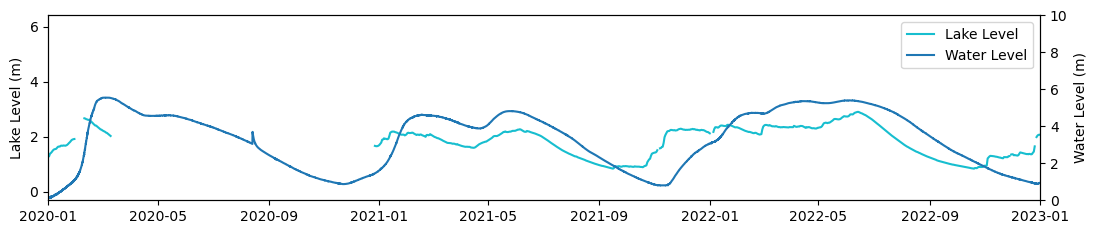

In [270]:
# crate figure lake level--------------------------------------------------------------------------------------------------------------------------
fig, (ax2) = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8*0.5))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
# ax1.plot(df['rsam'], label='2-5 Hz', alpha=1)
# ax1.plot(df['mf'], label='4.5-8 Hz', alpha=0.8, color='C2')
# ax1.plot(df['hf'], label='8-16 Hz', alpha=0.6, color='C8')

ax2.plot(lakelevel['rel_LakeLevel(meter)'], label='Lake Level', alpha=1, color='C9')
ax2.plot(np.nan, label='Water Level', alpha=1, color='C0')
ax22 = ax2.twinx()
ax22.plot(borehole['rel_borehole(meter)'], label ='Water Level')
    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
# ax1.legend(loc='center left')
ax2.legend(loc='upper right')

# linear y-axis
# ax1.set_ylabel('RSAM')
# ax1.set_ylim(1,200)
ax2.set_ylabel('Lake Level (m)')
# ax2.set_ylim(1,2)
ax22.set_ylabel('Water Level (m)')
ax22.set_ylim(0,10)

# ax1.set_xlim(df.index[0], df.index[-1])
ax2.set_xlim(datetime.datetime(2020,1,1), datetime.datetime(2023,1,1))

## Old

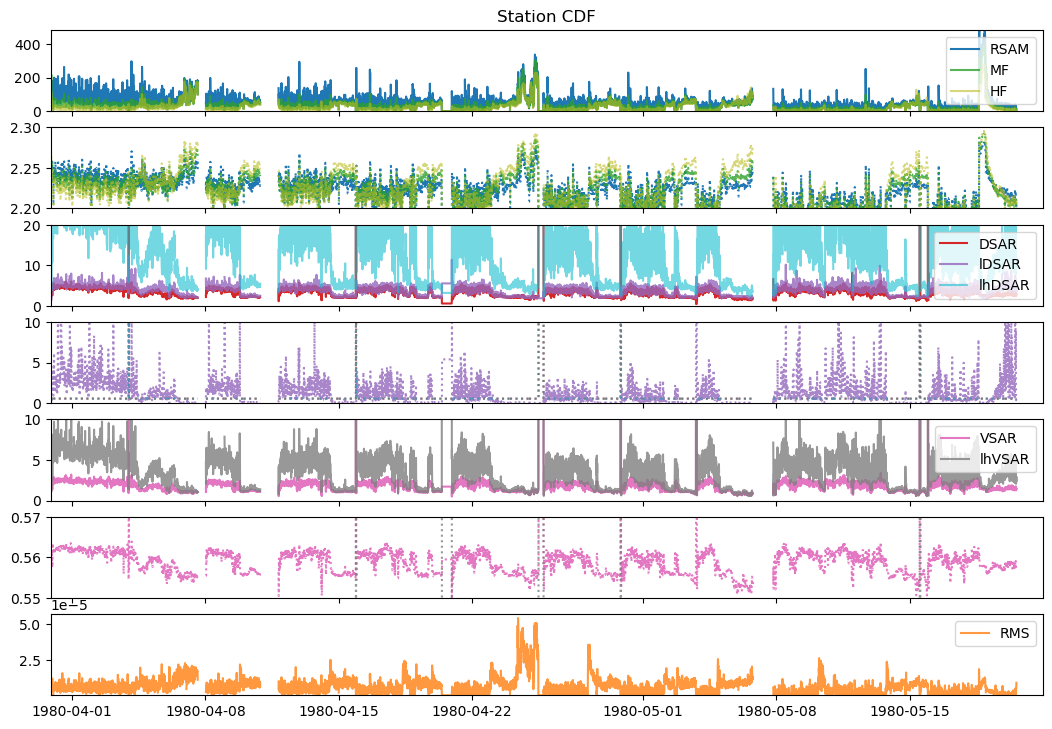

In [22]:
# crate figure --------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4) = plt.subplots(7,1, sharex=True, figsize=(6.4*2, 4.8*1.8))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=1)
ax1.plot(df['mf'], label='MF', alpha=0.8, color='C2')
ax1.plot(df['hf'], label='HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=1)
ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.8, color='C2')
ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.6, color='C8')
ax11.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8, color='C4')
ax2.plot(df['lhdsar'], label='lhDSAR', alpha=0.6, color='C9')
ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['lhdsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['lhdsar'].max()))

ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=1, color='C3')
ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.8, color='C4')
ax22.plot(df['zsc2_lhdsar'], linestyle=':', alpha=0.6, color='C9')
ax22.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_lhdsar'].min()),
              max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_lhdsar'].max()))

ax3.plot(df['vsar'], label='VSAR', alpha=1, color='C6')
ax3.plot(df['lhvsar'], label='lhVSAR', alpha=0.8, color='C7')
ax3.set_ylim(min(df['vsar'].min(),df['lhvsar'].min()),max(df['vsar'].max(),df['lhvsar'].max()))

ax33.plot(df['zsc2_vsar'], linestyle=':', alpha=1, color='C6')
ax33.plot(df['zsc2_lhvsar'], linestyle=':', alpha=0.8, color='C7')
ax33.set_ylim(min(df['zsc2_vsar'].min(),df['zsc2_lhvsar'].min()),max(df['zsc2_vsar'].max(),df['zsc2_lhvsar'].max()))

ax4.plot(df['rms'], label='RMS', alpha=0.8, color='C1')
ax4.set_ylim(df['rms'].min()),df['rms'].max()

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
# #     plt.axvline(sdate, color='k',linestyle=':')
#     ax1.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax11.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax2.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax22.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax3.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax33.axvspan(sdate, edate, alpha=0.25, color=color[i])
#     ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])

# sdate = datetime.datetime(1980,5,18)
# ax1.vlines(sdate, color='k', linestyle='--'); ax11.vlines(sdate, color='k', linestyle='--')
# ax2.vlines(sdate, color='k', linestyle='--'); ax22.vlines(sdate, color='k', linestyle='--')
# ax3.vlines(sdate, color='k', linestyle='--'); ax33.vlines(sdate, color='k', linestyle='--')
# ax4.vlines(sdate, color='k', linestyle='--')
    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

# # linear y-axis
ax11.set_ylim(2.2,2.3)
ax2.set_ylim(0,20); ax22.set_ylim(0,10)
ax3.set_ylim(0, 10); ax33.set_ylim(0.55, 0.57)


# log y-axis
# ax1.set_yscale('log');ax11.set_yscale('log')
# ax2.set_yscale('log');ax22.set_yscale('log')
# ax3.set_yscale('log');ax33.set_yscale('log')
# ax4.set_yscale('log')

# ax1.set_ylim(1e0, 1e4); ax11.set_ylim(2e-4,1e3)
# ax2.set_ylim(2e-1,3e1); ax22.set_ylim(2e-3, 1e3)
# ax3.set_ylim(1e-1,8e0); ax33.set_ylim(2e-3, 1e3)
# ax4.set_ylim(1e-7,1e-4)
              
ax1.set_xlim(df.index[0], df.index[-1])

# save plot and show -----------------------------------------------------------------------------------------------------------------
file_path = '../plots/{}/'.format(year)
os.makedirs(file_path, exist_ok=True) # bild path to save figures if it does not exist yet

# plt.savefig(file_path+'{}_log_long_dome_roll10D_4.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig(file_path+'{}_long_roll1D.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

In [ ]:
# adaptet code to plot 1980
# crate figure --------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4) = plt.subplots(7,1, sharex=True, figsize=(6.4*2, 4.8*1.8))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=1)
ax1.plot(df['mf'], label='MF', alpha=0.8, color='C2')
ax1.plot(df['hf'], label='HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=1)
ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.8, color='C2')
ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.6, color='C8')
ax11.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

ax2.plot(df['lhdsar'], label='lhDSAR', alpha=0.6, color='C9')

# ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['lhdsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['lhdsar'].max()))

ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.8, color='C4')
# ax22.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_lhdsar'].min()),
#               max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_lhdsar'].max()))

ax3.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax3.plot(df['ldsar'], label='lDSAR', alpha=0.8, color='C4')
ax3.plot(df['vsar'], label='VSAR', alpha=1, color='C6')
ax3.plot(df['lhvsar'], label='lhVSAR', alpha=0.8, color='C7')
# ax3.set_ylim(min(df['vsar'].min(),df['lhvsar'].min()),max(df['vsar'].max(),df['lhvsar'].max()))

ax33.plot(df['zsc2_dsar'],linestyle=':', alpha=1, color='C3')
ax33.plot(df['zsc2_lhdsar'], linestyle=':', alpha=0.6, color='C9')
ax33.plot(df['zsc2_vsar'], linestyle=':', alpha=1, color='C6')
ax33.plot(df['zsc2_lhvsar'], linestyle=':', alpha=0.8, color='C7')
# ax33.set_ylim(min(df['zsc2_vsar'].min(),df['zsc2_lhvsar'].min()),max(df['zsc2_vsar'].max(),df['zsc2_lhvsar'].max()))

ax4.plot(df['rms'], label='RMS', alpha=0.8, color='C1')
ax4.set_ylim(df['rms'].min()),df['rms'].max()

# plot dome periodes ------------------------------------------------------------------------------------------------------------------
color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

for i in range(len(activity_dome_start)):
    sdate = activity_dome_start.index[i].to_pydatetime() # start date
    edate = activity_dome_end.index[i].to_pydatetime() # end date
#     plt.axvline(sdate, color='k',linestyle=':')
    ax1.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax11.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax2.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax22.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax3.axvspan(sdate, edate, alpha=0.25, color=color[i]); ax33.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax4.axvspan(sdate, edate, alpha=0.25, color=color[i])

    
ax1.vlines(UTCDateTime('1980-05-18T00:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
ax11.vlines(UTCDateTime('1980-05-18T00:00:00'),ax11.get_ylim()[0],ax11.get_ylim()[-1], 'k','--')
ax2.vlines(UTCDateTime('1980-05-18T00:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
ax22.vlines(UTCDateTime('1980-05-18T00:00:00'),ax22.get_ylim()[0],ax22.get_ylim()[-1], 'k','--')
ax3.vlines(UTCDateTime('1980-05-18T00:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
ax33.vlines(UTCDateTime('1980-05-18T00:00:00'),ax33.get_ylim()[0],ax33.get_ylim()[-1], 'k','--')
ax4.vlines(UTCDateTime('1980-05-18T00:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')
    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

# # linear y-axis
# ax11.set_ylim(2.2,2.3)
# ax3.set_ylim(0, 10); ax33.set_ylim(0.48, 0.58)
ax11.set_ylim(2.2,2.3)
ax2.set_ylim(0,25); ax22.set_ylim(0,10)
ax3.set_ylim(0, 10); ax33.set_ylim(0.55, 0.58)


# log y-axis
# ax1.set_yscale('log');ax11.set_yscale('log')
# ax2.set_yscale('log');ax22.set_yscale('log')
# ax3.set_yscale('log');ax33.set_yscale('log')
# ax4.set_yscale('log')

# ax1.set_ylim(1e0, 1e4); ax11.set_ylim(2e-4,1e3)
# ax2.set_ylim(2e-1,3e1); ax22.set_ylim(2e-3, 1e3)
# ax3.set_ylim(1e-1,8e0); ax33.set_ylim(2e-3, 1e3)
# ax4.set_ylim(1e-7,1e-4)
              
ax1.set_xlim(df.index[0], df.index[-1])

# save plot and show -----------------------------------------------------------------------------------------------------------------
file_path = '../plots/{}/'.format(year)
os.makedirs(file_path, exist_ok=True) # bild path to save figures if it does not exist yet

# plt.savefig(file_path+'{}_log_long_dome_roll10D_4.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig(file_path+'{}_long_roll1D.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

In [ ]:
# all_files = sorted(glob.glob('../{}_*_extended2.csv'.format(year)))
# sta_list = np.unique([file.split('/')[1].split('_')[1] for file in all_files])
# year = 2000
sta_list = ['FL2', 'CDF']
for sta in sta_list:
#     df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta))
    df = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.resample('10min').median()
    
#     df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)
        
    df = df.rolling('6H', center=True, closed='both').median()
    df['rsam_median'] = df['rsam'].rolling('2D').median()
    df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
    df['dsar_median'] = df['dsar'].rolling('2D').median()
    df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
    df['rms_median'] = df['rms'].rolling('2D').median()
    df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
    df['pga_median'] = df['pga'].rolling('2D').median()
    df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()
#     df = df.resample('1H').median()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8))

    ax1.plot(df['rsam'], label='RSAM', alpha=0.8)
    ax1.plot(df['mf'], label='MF', alpha=0.8)
    ax1.plot(df['hf'], label='HF', alpha=0.8)
    ax1.plot(df['rsam_median'], label='RSAM med',color='k')
    ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

    ax11 = ax1.twinx()
    ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.5)
    ax11.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

    ax2.plot(df['dsar'], label='DSAR', alpha=0.8)
    ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8)
    ax2.plot(df['vsar'], label='VSAR', alpha=0.8)
    ax2.plot(df['dsar_median'], label='DSAR med',color='k')
    ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['vsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['vsar'].max()))

    ax22 = ax2.twinx()
    ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_vsar'], linestyle=':', alpha=0.5)
    ax22.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_vsar'].min()),
                  max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_vsar'].max()))
#     ax2.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
#     ax2.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')

    ax3.plot(df['rms'], label='RMS', alpha=0.8)
    ax3.plot(df['rmes'], label='RMeS', alpha=0.8)
    ax3.plot(df['rms_median'], label='RMS med',color='k')
#     ax3.plot(df['pgv'], label='PGV', alpha=0.8)
#     ax3.plot(df['pga'], label='PGA', alpha=0.8)
#     ax3.set_ylim(0,max(df['rms'].max(),df['rmes'].max(),df['pgv'].max(),df['pga'].max())) # linear
    ax3.set_ylim(min(df['rms'].min(),df['rmes'].min()),max(df['rms'].max(),df['rmes'].max()))


    ax33 = ax3.twinx()
    ax33.plot(df['zsc2_rms'],linestyle=':', alpha=0.5)
    ax33.plot(df['zsc2_rmes'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
#     ax33.set_ylim(0,max(df['zsc2_rms'].max(),df['zsc2_rmes'].max(),df['zsc2_pgv'].max(),df['zsc2_pga'].max())) # linear
    ax33.set_ylim(min(df['zsc2_rms'].min(),df['zsc2_rmes'].min()),max(df['zsc2_rms'].max(),df['zsc2_rmes'].max()))      

    ax4.plot(df['pgv'], label='PGV', alpha=0.8)
    ax4.plot(df['pga'], label='PGA', alpha=0.8)
    ax4.plot(df['pga_median'], label='PGA med',color='k')
    ax4.set_ylim(min(df['pgv'].min(),df['pga'].min()),max(df['pgv'].max(),df['pga'].max())) # linear

    ax44 = ax4.twinx()
    ax44.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
    ax44.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
    ax44.set_ylim(min(df['zsc2_pgv'].min(),df['zsc2_pga'].min()),max(df['zsc2_pgv'].max(),df['zsc2_pga'].max()))
    
    ax1.set_xlim(df.index[0], df.index[-1])
    ax1.vlines(UTCDateTime('2004-09-23T09:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-09-23T09:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-09-23T09:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-09-23T09:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')
    
#     ax1.vlines(UTCDateTime('2004-10-01T19:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
#     ax2.vlines(UTCDateTime('2004-10-01T19:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
#     ax3.vlines(UTCDateTime('2004-10-01T19:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
#     ax4.vlines(UTCDateTime('2004-10-01T19:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')

    ax1.set_title('Station {}'.format(sta))
    ax1.legend(ncol=2, loc='upper right')
    ax2.legend(ncol=2, loc='upper right')
    ax3.legend(ncol=2, loc='upper right')
    ax4.legend(ncol=2, loc='upper right')
    
    ax1.set_yscale('log');ax11.set_yscale('log')
    ax2.set_yscale('log');ax22.set_yscale('log')
    ax3.set_yscale('log');ax33.set_yscale('log')
    ax4.set_yscale('log');ax44.set_yscale('log')

    
#     file_path = '../plots/{}/'.format(year)
    file_path = '../plots/'
    if not os.path.exists(file_path): # create path if not exist
        os.makedirs(file_path)
#     plt.savefig(file_path+'{}_{}_log_long.png'.format(year,year,sta), dpi=300, bbox_inches='tight')
    plt.savefig(file_path+'{}_log_long.png'.format(sta), dpi=300, bbox_inches='tight')
    fig.show()

In [ ]:
# NORMALIZED plot
year = 2004
sta_list = ['SEP']
# or for all avaivable stations
# all_files = sorted(glob.glob('../data/{}_*_extended2.csv'.format(year)))
# sta_list = np.unique([file.split('/')[2].split('_')[1] for file in all_files])
#============================================================================================
for sta in sta_list:
    df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta)) # read data from csv
#     df = pd.read_csv('../{}_extended2_long.csv'.format(sta))
    df.set_index('time',inplace=True) # set time as index
    df.index = pd.to_datetime(df.index).tz_localize(None) # convert time to datetime
    df = df.resample('10min').median() # resample to 10 min if data gaps
    
    df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)
        
    df = df.rolling('6H', center=True).median() # roll over 6 hours and take median (whole df)
#     df = df.resample('1H').median() # resample over 1 hour and take median (whole df)
    # roll over 2 days and take median (column of interest)
    df['rsam_median'] = df['rsam'].rolling('2D').median() 
    df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
    df['dsar_median'] = df['dsar'].rolling('2D').median()
    df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
    df['rms_median'] = df['rms'].rolling('2D').median()
    df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
    df['pga_median'] = df['pga'].rolling('2D').median()
    df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()

    df = df.apply(norm,axis=0) # normalize all timesiries individual
    
# start plotting ========================================================================================
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*1.5))
    
    # first subplot left side ---------------------------------------------------------------------------
    ax1.plot(df['rsam'], label='RSAM', alpha=0.8)
    ax1.plot(df['mf'], label='MF', alpha=0.8)
    ax1.plot(df['hf'], label='HF', alpha=0.8)
    ax1.plot(df['rsam_median'], label='RSAM med',color='k')

    # first subplot right side ---------------------------------------------------------------------------
    ax11 = ax1.twinx()
    ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.5)

    # second subplot left side ---------------------------------------------------------------------------
    ax2.plot(df['dsar'], label='DSAR', alpha=0.8)
    ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8)
    ax2.plot(df['vsar'], label='VSAR', alpha=0.8)
    ax2.plot(df['dsar_median'], label='DSAR med',color='k')

    # second subplot right side ---------------------------------------------------------------------------
    ax22 = ax2.twinx()
    ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_vsar'], linestyle=':', alpha=0.5)
#     ax2.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
#     ax2.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')

    # third subplot left side ---------------------------------------------------------------------------
    ax3.plot(df['rms'], label='RMS', alpha=0.8)
    ax3.plot(df['rmes'], label='RMeS', alpha=0.8)
    ax3.plot(df['rms_median'], label='RMS med',color='k')
#     ax3.plot(df['pgv'], label='PGV', alpha=0.8)
#     ax3.plot(df['pga'], label='PGA', alpha=0.8)

    # third subplot right side ---------------------------------------------------------------------------
    ax33 = ax3.twinx()
    ax33.plot(df['zsc2_rms'],linestyle=':', alpha=0.5)
    ax33.plot(df['zsc2_rmes'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)

    # fourth subplot left side ---------------------------------------------------------------------------
    ax4.plot(df['pgv'], label='PGV', alpha=0.8)
    ax4.plot(df['pga'], label='PGA', alpha=0.8)
    ax4.plot(df['pga_median'], label='PGA med',color='k')

    # fourth subplot right side ---------------------------------------------------------------------------
    ax44 = ax4.twinx()
    ax44.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
    ax44.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
    
    # vertical line fror eruption date ----------------------------------------------------------------
    ax1.vlines(UTCDateTime('2004-09-23T09:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-09-23T09:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-09-23T09:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-09-23T09:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')
    
    ax1.vlines(UTCDateTime('2004-10-01T19:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-10-01T19:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-10-01T19:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-10-01T19:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')

    # legend  ---------------------------------------------------------------------------
    ax1.legend(ncol=2, loc='upper left')
    ax2.legend(ncol=2, loc='upper left')
    ax3.legend(ncol=2, loc='upper left')
    ax4.legend(ncol=2, loc='upper left')
    
    ax1.set_title('Station {}'.format(sta))
    
#     file_path = '../plots/{}/'.format(year)
#     if not os.path.exists(file_path): # create path if not exist
#         os.makedirs(file_path)
#     plt.savefig('../plots/{}/{}_{}_norm.png'.format(year,year,sta), dpi=300, bbox_inches='tight')

    fig.show()

In [ ]:
sta_list = ['JUN','YEL','SEP','STD','EDM','SHW','HSR','SOS','TDL','ELK','FL2','CDF']
for sta in sta_list:
#     all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/{}/*.csv'.format(sta)))
#     li = []
#     for filename in all_files:
#         frame = pd.read_csv(filename)
#         li.append(frame)

#     df = pd.concat(li, axis=0, ignore_index=True)
#     df.set_index('time',inplace=True)
#     df.index = pd.to_datetime(df.index).tz_localize(None)
#     df.sort_index()

#     # compute transforms and save
#     df['zsc2_rsam'] = zsc2(df['rsam'])
#     df['zsc2_mf'] = zsc2(df['mf'])
#     df['zsc2_hf'] = zsc2(df['hf'])
#     df['zsc2_dsar'] = zsc2(df['dsar'])

#     df.to_csv('../{}_extended.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')
       
    df = pd.read_csv('../{}_extended.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.rolling('6H', center=True).median()
    df['dsar_median'] = df[['dsar']].rolling(2*24*6).median()
    df['zsc2_dsar_median'] = df[['zsc2_dsar']].rolling(2*24*6).median()
    # df = df.resample('1H').median()

    fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))

    ax.plot(df['rsam'], label='RSAM', alpha=0.5)
    ax.plot(df['mf'], label='MF', alpha=0.5)
    ax.plot(df['hf'], label='HF', alpha=0.5)
    ax.plot(np.nan, label='DSAR')
    ax.plot(np.nan, label='zsc DSAR')
    ax.plot(np.nan, label='median zsc DSAR', color='k')
    ax.plot(np.nan, label='eq swarm', color='k',linestyle='--')
    ax.set_ylim(0,5e3) # linear
    # ax.set_ylim(1e-2,1e4) # log
    # ax.set_yscale('log')

    ax2 = ax.twinx()
    ax2.spines.right.set_color('C3')
    ax2.tick_params(axis='y', colors='C3')
    ax2.tick_params(axis='y', colors='C3')
    ax2.plot(df['dsar'], label='DSAR', color='C3', alpha=0.5)
    ax2.plot(df['dsar_median'], label='median DSAR', color='k')
    ax2.set_ylim(0,7)

    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.03))
    ax3.spines.right.set_color('C4')
    ax3.tick_params(axis='y', colors='C4')
    ax3.tick_params(axis='y', colors='C4')
    ax3.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
    ax3.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')
    ax3.set_ylim(0,120)

    ax.set_xlim(df.index[0], df.index[-1])
    ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

    ax.set_title('UW-{}-EHZ'.format(sta))
    ax.legend(ncol=2, loc='upper left')
    fig.show()

In [ ]:
# NORMALIZATION
df_dsar_median = pd.DataFrame()
df_zscdsar_median = pd.DataFrame()

sta_list = ['JUN','YEL','SEP','STD','EDM','SHW','HSR','SOS','TDL','ELK','FL2','CDF']
for sta in sta_list:
#     all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/{}/*.csv'.format(sta)))
#     li = []
#     for filename in all_files:
#         frame = pd.read_csv(filename)
#         li.append(frame)

#     df = pd.concat(li, axis=0, ignore_index=True)
#     df.set_index('time',inplace=True)
#     df.index = pd.to_datetime(df.index).tz_localize(None)
#     df.sort_index()

#     # compute transforms and save
#     df['zsc2_rsam'] = zsc2(df['rsam'])
#     df['zsc2_mf'] = zsc2(df['mf'])
#     df['zsc2_hf'] = zsc2(df['hf'])
#     df['zsc2_dsar'] = zsc2(df['dsar'])

#     df.to_csv('../{}_extended.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')
    
    
    df = pd.read_csv('../{}_extended.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.rolling('12H', center=True).median()
    df['dsar_median'] = norm(df['dsar']).rolling(2*24*6).median()
    df['zsc2_dsar_median'] = norm(df['zsc2_dsar']).rolling(2*24*6).median()
    # df = df.resample('1H').median()
    df_dsar_median['{}'.format(sta)] = df['dsar_median']
    df_zscdsar_median['{}'.format(sta)] = df['zsc2_dsar_median']

    fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))

    ax.plot(norm(df['rsam']), label='RSAM', alpha=0.5)
    ax.plot(norm(df['mf']), label='MF', alpha=0.5)
    ax.plot(norm(df['hf']), label='HF', alpha=0.5)
    ax.plot(np.nan, label='DSAR')
    ax.plot(np.nan, label='zsc DSAR')
    ax.plot(np.nan, label='median zsc DSAR', color='k')
    ax.plot(np.nan, label='eq swarm', color='k',linestyle='--')
#     ax.set_ylim(0,5e3) # linear
    # ax.set_ylim(1e-2,1e4) # log
    # ax.set_yscale('log')

    ax.plot(norm(df['dsar']), label='DSAR', color='C3', alpha=0.5)
    ax.plot(df['dsar_median'], label='median DSAR', color='k')
#     ax2.set_ylim(0,7)

    ax.plot(norm(df['zsc2_dsar']), label='zscDSAR', color='C4', alpha=0.5)
    ax.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')
#     ax3.set_ylim(0,120)
    ax.set_ylim(0,1)
    ax.set_xlim(df.index[0], df.index[-1])
    ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

    ax.set_title('UW-{}-EHZ'.format(sta))
    ax.legend(ncol=2, loc='upper left')
    fig.show()